This Example teaches the user to use the `main.evolve()` function.  Given a model of decaying or annihilating DM, `main.evolve()` will compute:

    (1) The free electron fraction as a function of redshift, $x_e(z) = n_e(z)/n_{HI}(z)$
    (2) The baryon temperature as a function of redshift, $T_m(z)$
    (3) The high energy photon spectra, and low energy photon/electron spectra as a function of z
    (4) The energy deposition fractions, $f_c(z)$

We will walk the user through an example of DM that either decays or (s-wave) annihilates into photons or $e^+ \, e^-$ pairs. We will calculate the effect of "backreaction" on the energy deposition fractions, $f_c(z)$.

# Start Shift-Entering from here, Hongwan---------

In [32]:
inj_type = 'decay'
inj_particle = 'electron'

# Full Transfer Functions

In [2]:
%load_ext autoreload
import sys
sys.path.append("..")

#Current Working Directory
import os
cwd = os.getcwd()

In [3]:
%autoreload

import matplotlib
matplotlib.rc_file('matplotlibrc')
import matplotlib.pyplot as plt

%matplotlib inline

matplotlib.rcParams['figure.figsize'] = [10,10]


from astropy.io import fits

import numpy as np
import copy
import pickle

import darkhistory.physics as phys
import darkhistory.utilities as utils
import darkhistory.spec.spectools as spectools
import darkhistory.spec.transferfunction as tf
import darkhistory.spec.transferfunclist as tflist
from darkhistory.spec.spectrum import Spectrum
from darkhistory.spec.spectra import Spectra
import darkhistory.history.tla as tla

from scipy.interpolate import interp1d
from scipy.interpolate import interp2d

from tqdm import tqdm_notebook as tqdm

from darkhistory.electrons.ics.ics_spectrum import ics_spec
from darkhistory.electrons.ics.ics_engloss_spectrum import engloss_spec
from darkhistory.electrons.ics.ics_cooling import get_ics_cooling_tf

from darkhistory.low_energy.lowE_deposition import compute_fs
import main

from tqdm import tqdm_notebook as tqdm

# np.set_printoptions(threshold=np.nan)

In the standard temperature/ionization history calculation,
one solves the TLA assuming no DM energy injection. 

$$ \dot{T}_m = -2 H T_m + \Gamma_C \left(T_{CMB} - T_m \right), $$
$$ \dot{x}_e = - \mathcal{C} \left[ n_H x_e^2 \alpha_B - 4 (1 - x_e) \beta_B e^{-E_{21}/T_{CMB}} \right]. $$

The solution to these coupled ODEs subject to the initial conditions 
$$\left. x_e \right|_{z=3000} = 1$$ $$\left( T_m = T_{CMB} \right)_{z=3000}$$ 
provides the standard $x_e$ and $T_m$ histories, which are loaded below.

In [4]:
soln = pickle.load(open("../darkhistory/history/std_soln.p", "rb"))
xe_std  = interp1d(soln[0,:], soln[2,:])
T_m_std = interp1d(soln[0,:], soln[1,:])

To include the effect of DM energy injection, one adds to the TLA the following terms

$$ \dot{T}^\chi_m = \frac{2 f_\text{heat}(z)}{3 (1 + f_\text{He} + x_e(z)) n_H(z)} \left(\frac{dE}{dV \, dt} \right)^\text{inj}, $$
$$ \dot{x}^\chi_e = \left[\frac{f_\text{ion}(z)}{\mathcal{R} n_H(z)} + \frac{(1-\mathcal{C}) \; f_\text{exc}(z)}{0.75 \mathcal{R} n_H(z)} \right] \left(\frac{dE}{dV \, dt} \right)^\text{inj}. $$

Apparently one must know $f_{c=\{\text{heat, ion, exc}\}}(z)$ for all z to solve the TLA, which requires a knowledge of the histories of $x_e(z)$ and the DM decay/annihilation products.  Below we will either generate the $f_c$'s by using the standard history values ("without back-reaction"), or by including the effects of DM energy injection ("with back-reaction").

The function _main.evolve()_ will numerically integrate the TLA either with or without back-reaction and generate the $f_c$'s during the integration.  The function requires a number of parameters:

- `in_spec_elec`, `in_spec_phot`:  The spectrum of electrons and photons that come from a single DM decay or annihilation event

- `rate_func_N`, `rate_func_eng`:  $\frac{dN}{dV dt}$ and $\frac{dE}{dV dt}$, particle number and energy injection rates per cubic volume

- `end_rs`: redshift at which the TLA integration ends

- `highengphot_tf_interp`, `lowengphot_tf_interp`, `lowengelec_tf_interp`: interpolated transfer functions for high energy photons and lowenergy photons and electrons

- `xe_init`, `Tm_init`: initial $x_e$ and $T_m$.  If unspecified, will be set to the standard solution.

- `coarsen_factor`:  Described in the next section. Default set to 1.

- `std_soln`: Turn backreaction on/off.  If True, compute TLA without backreaction.  If False, include back-reaction.

We will now calculate each of these parameters.

## Photon Transfer Functions

`highengphot_tf_interp`, `lowengphot_tf_interp`, and `lowengelec_tf_interp`: 

Transfer functions encode how particles (photons and electrons in our case) transfer energy as they evolve within the expanding universe.  For example, a high energy photon will lose energy through redshifting and scattering off of free electrons, producing lower energy photons in the process (what else am I missing???).  

In the following we will assume that particle energies will be binned within log-spaced energy intervals whose log-centers are given by $E^i$ = $E^0 e^{\Delta i}$ for some $\Delta$. Let $E_{in}^i$ be the energy of a single photon injected at redshift $z_{in}$. Due to energy transfer processes that took place over $d(\ln(1+z))$ worth of cosmological time, the photon produces $N^j$ photons at energies $E_{out}^j$.  If we define our transfer function $T^{ij} \equiv T(E_{in}^i, E_{out}^j)$, we have

$$ N_\gamma\left(E^j, (1+z_{in})e^{- d(\ln(1+z))} \right) = T^{ij} N_\gamma\left(E^i, 1+z_{in} \right), $$

where $N_\gamma(E, 1+z)$ represents the number of photons of energy E at redshift 1+z.  The transfer function allows us to evolve photon spectra $d(\ln(1+z))$ amount of time.  This information allows us to evolve DM decay/annihilation products forward in time. We will set $d(\ln(1+z))$ = $0.002$ in our transfer functions, which has been shown to be small enough to provide convergent results.  

Additionally, one may increase the speed of the TLA integration at the expense of precision by "coarsening." This is a process that combines multiples of `coarsen_factor` transfer functions to produce ones that evolve spectra forward by $d(\ln(1+z))$ = $0.002 \; \times$ `coarsen_factor`.  We will avoid coarsening in our example by setting `coarsen_factor` to 1.

We now load the transfer functions. (!!! We should load from some folder in the user's DarkHistory directory that they had to make at some other point)

In [5]:
user = '/home/gridgway'
highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp, CMB_engloss_arr = main.load_trans_funcs(user+'/Dropbox (MIT)/Photon Deposition/')

Loading transfer functions...
Loaded high energy photons...
Low energy photons...
Low energy electrons...
CMB losses.

Padding tflists with zeros...
high energy photons...
low energy photons...
low energy electrons...

CMB losses.

Generating TransferFuncInterp objects for each tflist...
Done.



The above objects are actually `TransferFuncInterpolation` objects.  When given an input $x_e$ and $E_{in}$, these objects output a corresponding transfer function. 

If we are considering annihilation/decay to $e^+ e^-$, then we must also load the ics-related transfer functions

In [33]:
if inj_particle == 'electron':
    ics_thomson_ref_tf, ics_rel_ref_tf, engloss_ref_tf = main.load_ics_data()

********* Thomson regime scattered photon spectrum *********
Initializing...
Computing spectra by an expansion in beta...
----> Computation by expansion in beta complete!
Computing spectra by analytic series...
*** Computing series 1/12...
*** Computing series 2/12...
*** Computing series 3/12...
*** Computing series 4/12...
*** Computing series 5/12...
*** Computing series 6/12...
*** Computing series 7/12...
*** Computing series 8/12...
*** Computing series 9/12...
*** Computing series 10/12...
*** Computing series 11/12...
*** Computing series 12/12...
----> Computation by analytic series complete!
Spectrum computed!
********* Relativistic regime scattered photon spectrum *********
Initializing...
Computing series 1/4...
Computing series 2/4...
Computing series 3/4...
Computing series 4/4...
Relativistic Computation Complete!
********* Thomson regime energy loss spectrum *********
Computing nonrelativistic energy loss spectrum...
Computing energy loss spectrum by beta expansion...
C

## Particle Number/Energy Injection Rates

`rate_func_N`, `rate_func_eng`:

The energy injection rate per volume of decaying DM is given by

$$ \left(\frac{dE}{dVdt}\right)_{inj} = \frac{\rho(z)}{\tau_{DM}} $$

and of s-wave annihilating DM by

$$ \left(\frac{dE}{dVdt}\right)_{inj} = \frac{\rho(z)^2}{m_{DM}} \sigma_0. $$

To derive the particle number injection rate, just divide by the center of mass energy, 

$$ \left(\frac{dN}{dVdt}\right)_{inj} = \left. \left(\frac{dE}{dVdt}\right)_{inj} \right/ E_{com} $$

which is $m_{DM}$ for decaying DM and $2 m_{DM}$ for annihilating DM.

In [7]:
mDM = 1e8
sigmav = 3e-26
tau = 1e23

if inj_type == 'decay':
    Ecom = mDM
else:
    Ecom = 2*mDM

Before we can write down the energy/particle number injection rate functions, we must take into account structure formation.

Structure formation has no effect on decay rates, but it serves to enhance annihilation rates due to the decreased interparticle spacing between DM particles.  What we have then is

$$ \left(\frac{dE}{dVdt}\right)_{inj} \longrightarrow \left(\frac{dE}{dVdt}\right)_{inj} \times \left(1 + B(z)\right) $$

where $B(z)$ is the structure formation boost factor.  Below we use the model given by Equation (2.7) in 1408.1109, which gives a boost factor of 

$$ B(z) = \frac{b_h}{(1+z)^\delta} \text{erfc} \left(\frac{1+z}{1+z_h} \right) $$

In [8]:
from scipy.special import erfc as erfc

b_h = 1.6e5
z_h = 19.5
delta = 1.54

def struct_boost_analytic(rs):
    boost_factor = b_h/rs**delta * erfc(rs/(1+z_h))
    return 1 + boost_factor

if inj_type is 'swave':
    struct_boost = struct_boost_analytic
elif inj_type is 'decay':
    def struct_boost(rs):
        return 1

def rate_func_N(rs):
    return phys.inj_rate(inj_type, rs, mDM=mDM, sigmav=sigmav, tau=tau)*struct_boost(rs)/Ecom
def rate_func_eng(rs):
    return phys.inj_rate(inj_type, rs, mDM=mDM, sigmav=sigmav, tau=tau)*struct_boost(rs)   

Alternatively, we could also use the boost factor given in arxiv:1604.02457, which we include below for convenience.  This structure boost uses input from N_Body simulation and assumes an Einasto DM halo profile including substructure.

In [9]:
struct_data = np.loadtxt(open(cwd+"/../structure_formation_data/boost_Einasto_subs.txt", "rb"))

log_struct_interp = interp1d(np.log(struct_data[:,0]), np.log(struct_data[:,1]))

def struct_boost_einasto(rs):
    return np.exp(log_struct_interp(np.log(rs)))

## Injected Electron and Photon Spectra

`in_spec_elec`, `in_spec_phot`:

Each DM decay/annihilation event produces a spectrum of electrons or photons.  For a decay event, the spectrum is two photons (one $e^+ e^-$ pair) of energy $m_{DM}/2$ ($m_{DM}/2 - m_e$) and for an annihilation event it is two photons (one $e^+ e^-$ pair) at $m_{DM}$ ($m_{DM} - m_e$).

In [10]:
if inj_particle is "electron":
    rest_energy = phys.me
elif inj_particle is "photon":
    rest_energy = 0
else:
    raise TypeError('Specify either electron or photon final state')

eng = highengphot_tf_interp.eng
if inj_type == 'decay':
    tmp_spec = spectools.rebin_N_arr(
        np.array([2]), # Number of particles in each bin
        np.array([mDM/2 - rest_energy]), # Energy of particles
        eng # Desired energy abscissa of tmp_spec
    )
else:
    tmp_spec = spectools.rebin_N_arr(np.array([2]), np.array([mDM - rest_energy]), eng)
    
tmp_spec.rs = 3000
tmp_spec.switch_spec_type()

if inj_particle is "electron":
    elec_spec_init =   tmp_spec
    phot_spec_init = 0*tmp_spec
else:
    phot_spec_init =   tmp_spec
    elec_spec_init = 0*tmp_spec

__Note__: the rs of `in_spec_elec` and `in_spec_phot` will define rs at which the TLA integration begins.

## main.evolve()

After specifying `end_rs`, we are ready to run main.evolve().

In [16]:
%autoreload
end_rs = 5
std_soln=True
coarsen_factor = 1

tau=1e23
a1 = main.evolve(
    elec_spec_init, phot_spec_init,
    rate_func_N, rate_func_eng, end_rs,
    highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp,
    #ics_thomson_ref_tf, ics_rel_ref_tf, engloss_ref_tf
    coarsen_factor=coarsen_factor, std_soln=std_soln
)
print('Done 1')
# tau = 1e24

# a2 = main.evolve(
#     elec_spec_init, phot_spec_init,
#     rate_func_N, rate_func_eng, 
#     end_rs,
#     highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp,
#     ics_thomson_ref_tf, ics_rel_ref_tf, engloss_ref_tf,
#     Tm_init=phys.TCMB(elec_spec_init.rs),
#     coarsen_factor=coarsen_factor, std_soln=std_soln
# )
# print('Done 2')
# tau=1e25

# a3 = main.evolve(
#     elec_spec_init, phot_spec_init,
#     rate_func_N, rate_func_eng, 
#     end_rs,
#     highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp,
#     ics_thomson_ref_tf, ics_rel_ref_tf, engloss_ref_tf,
#     Tm_init=phys.TCMB(elec_spec_init.rs),
#     coarsen_factor=coarsen_factor, std_soln=std_soln
# )
# print('Done 3')

# b = main.evolve(
#     phot_spec_init*0, phot_spec_init,
#     rate_func_N, rate_func_eng, 
#     end_rs,
#     highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp, 
#     coarsen_factor=1, std_soln=False
# )

110697138593789.12
111026565744424.72
111356953000679.34
111688302982156.23
112020618313998.9
112353901626887.88
112688155557036.84
113023382746189.16
113359585841613.7
113696767496100.7
114034930367957.67
114374077121004.48
114714210424569.14
115055332953482.42
115397447388073.19
115740556414162.86
116084662723060.0
116429769011554.7
116775877981912.7
117122992341869.27
117471114804622.94
117820248088828.97
118170394918592.83
118521558023463.17
118873740138424.66
119226944003890.75
119581172365696.2
119936427975089.1
120292713588723.1
120650031968649.06
121008385882306.7
121367778102515.95
121728211407468.03
122089688580716.25
122452212411166.92
122815785693069.4
123180411226006.62
123546091814884.75
123912830269923.1
124280629406643.36
124649492045859.0
125019421013664.05
125390419141421.9
125762489265753.77
126135634228526.69
126509856876841.72
126885160063021.4
127261546644597.27
127639019484296.84
128017581450030.69
128397235414878.8
128777984257077.12
129159830860003.5
1295427781

[5, 2000.0, 1, 10000.0]

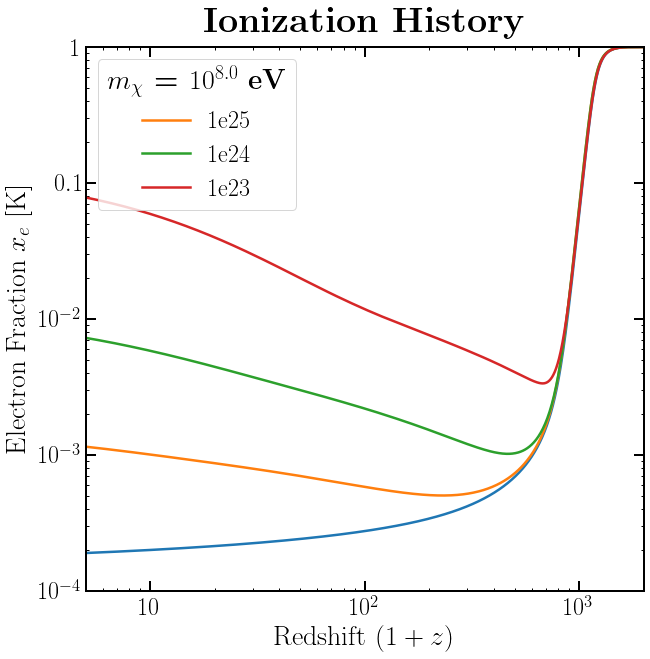

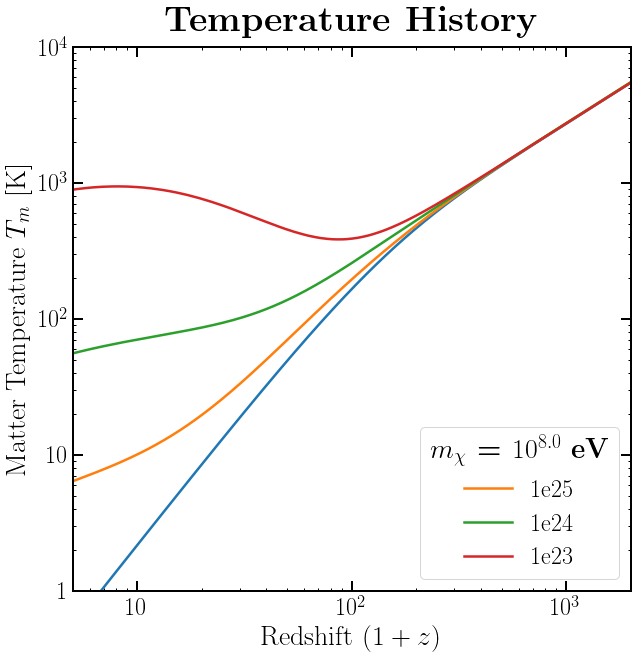

In [400]:
# plt.figure()
# plt_0, = plt.plot(soln[0,:], soln[2,:], label='None')
# plt_3, = plt.plot(a3[3].rs, a3[0], label='1e25')
# plt_2, = plt.plot(a2[3].rs, a2[0], label='1e24')
# plt_1, = plt.plot(a1[3].rs, a1[0], label='1e23')

# ax = plt.gca()
# ax.set_xscale('log')
# ax.set_yscale('log')
# plt.title(r'\bf{Ionization History}')
# plt.xlabel(r'Redshift $(1+z)$')
# plt.ylabel(r'Electron Fraction $x_e$ [K]')
# leg = plt.legend(handles=[plt_3, plt_2, plt_1],
#                  title=r'$m_\chi$\bf{ = $10^{'+str(np.log10(mDM))+'}$ eV}',
#                  loc=2
#                 )
# plt.setp(leg.get_title(),fontsize=28)
# plt.axis([5, 2e3, 1e-4, 1])
# #plt.savefig('/home/gridgway/Desktop/xe_decay_comparison.png')

# plt.figure()
# plt_T0, = plt.plot(soln[0,:], soln[1,:]/phys.kB, label='None')
# plt_T3, = plt.plot(a3[3].rs, a3[1]/phys.kB, label='1e25')
# plt_T2, = plt.plot(a2[3].rs, a2[1]/phys.kB, label='1e24')
# plt_T1, = plt.plot(a1[3].rs, a1[1]/phys.kB, label='1e23')

# # plt.plot(b[3].rs, phys.TCMB(b[3].rs)/phys.kB, 'k:')
# ax = plt.gca()
# ax.set_xscale('log')
# ax.set_yscale('log')
# plt.title(r'\bf{Temperature History}')
# plt.xlabel(r'Redshift $(1+z)$')
# plt.ylabel(r'Matter Temperature $T_m$ [K]')
# leg2 = plt.legend(handles=[plt_T3, plt_T2, plt_T1],
#                   title=r'$m_\chi$\bf{ = $10^{'+str(np.log10(mDM))+'}$ eV}',
#                   loc=4
#                  )
# plt.setp(leg2.get_title(),fontsize=28)
# plt.axis([5, 2e3, 1, 1e4])
# #plt.savefig('/home/gridgway/Desktop/Tm_decay_comparison.png')

In [25]:
def f_H_ion(rs, xe):
    interp_func = interp2d(log10eng, log10rs, log10f_phot_decay['H_ion'])
    return 10**interp_func(np.log10(mDM), np.log10(rs))[0]

def f_H_exc(rs, xe):
    interp_func = interp2d(log10eng, log10rs, log10f_phot_decay['H_exc'])
    return 10**interp_func(np.log10(mDM), np.log10(rs))[0]

def f_heating(rs, xe):
    interp_func = interp2d(log10eng, log10rs, log10f_phot_decay['heating'])
    return 10**interp_func(np.log10(mDM), np.log10(rs))[0]

[5, 3000.0, 0.0001, 1]

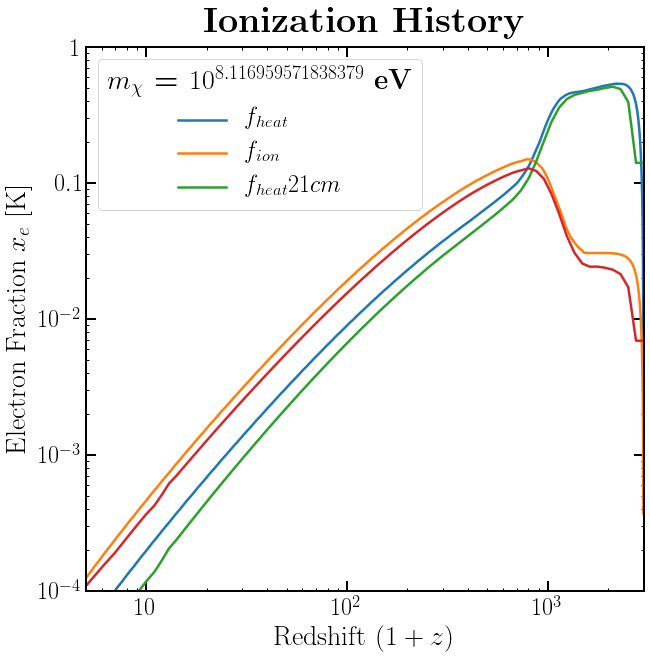

In [63]:
mDM=10**log10eng[19]
soln = np.loadtxt(open("/home/gridgway/Desktop/DarkHistory/darkhistory/history/recfast_standard.txt", "rb"))
tmp = np.array([f_heating(rs,xe) for rs,xe in zip(soln[:,0], soln[:,1])])
tmp2 = np.array([f_H_ion(rs,xe) for rs,xe in zip(soln[:,0], soln[:,1])])

plt.figure()
plt_0, = plt.plot(a1[3].rs[1:], a1[5][:,3], label='$f_{heat}$')
plt_1, = plt.plot(a1[3].rs[1:], a1[5][:,0], label='$f_{ion}$')
plt_2, = plt.plot(soln[:,0], tmp, label='$f_{heat} 21cm$')
plt_3, = plt.plot(soln[:,0], tmp2, label='$f_{ion} 21cm$')

# plt_2, = plt.plot(a2[3].rs[1:], a2[5][:,3], label='$f_{ion}$')
# plt_3, = plt.plot(a2[3].rs[1:], a2[5][:,0], label='$f_{heat}$')

ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
plt.title(r'\bf{Ionization History}')
plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel(r'Electron Fraction $x_e$ [K]')
leg = plt.legend(handles=[plt_0, plt_1, plt_2],#, plt_2, plt_3],
                 title=r'$m_\chi$\bf{ = $10^{'+str(np.log10(mDM))+'}$ eV}',
                 loc=2
                )
plt.setp(leg.get_title(),fontsize=28)
plt.axis([5, 3e3, 1e-4, 1])
# plt.savefig('/home/gridgway/Desktop/shifted_fs.png')

[5, 2000.0, 0.0001, 1]

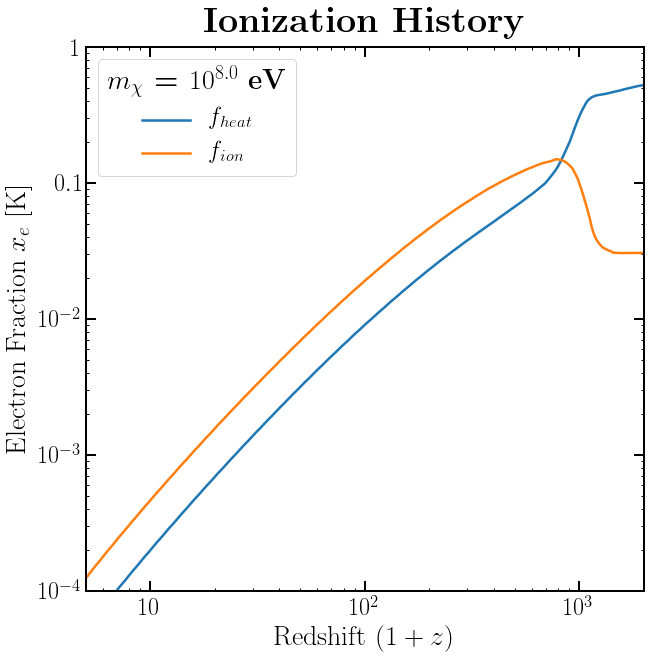

In [399]:
plt.figure()
plt_0, = plt.plot(a1[3].rs[1:], a1[5][:,3], label='$f_{heat}$')
plt_1, = plt.plot(a1[3].rs[1:], a1[5][:,0], label='$f_{ion}$')

# plt_2, = plt.plot(a2[3].rs[1:], a2[5][:,3], label='$f_{ion}$')
# plt_3, = plt.plot(a2[3].rs[1:], a2[5][:,0], label='$f_{heat}$')

ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
plt.title(r'\bf{Ionization History}')
plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel(r'Electron Fraction $x_e$ [K]')
leg = plt.legend(handles=[plt_0, plt_1],#, plt_2, plt_3],
                 title=r'$m_\chi$\bf{ = $10^{'+str(np.log10(mDM))+'}$ eV}',
                 loc=2
                )
plt.setp(leg.get_title(),fontsize=28)
plt.axis([5, 2e3, 1e-4, 1])
# plt.savefig('/home/gridgway/Desktop/shifted_fs.png')

# Stop Hitting shift-enter now, Hongwan---------

[5, 2000.0, 1, 10000.0]

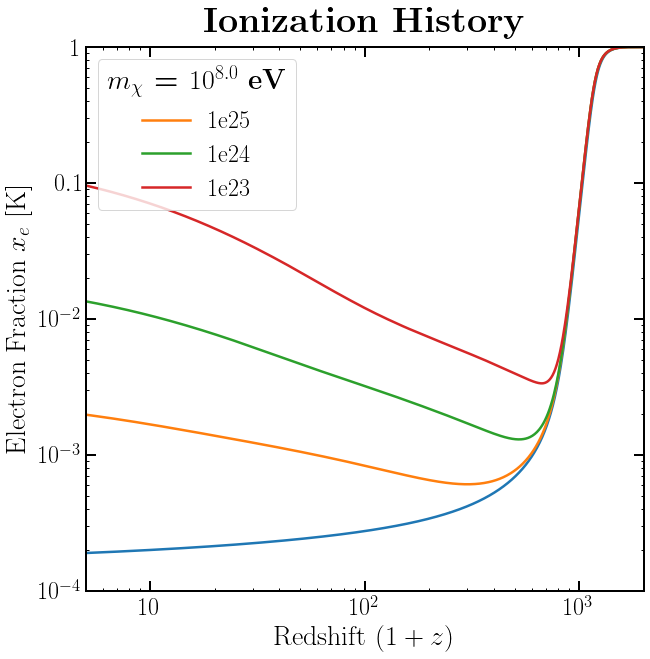

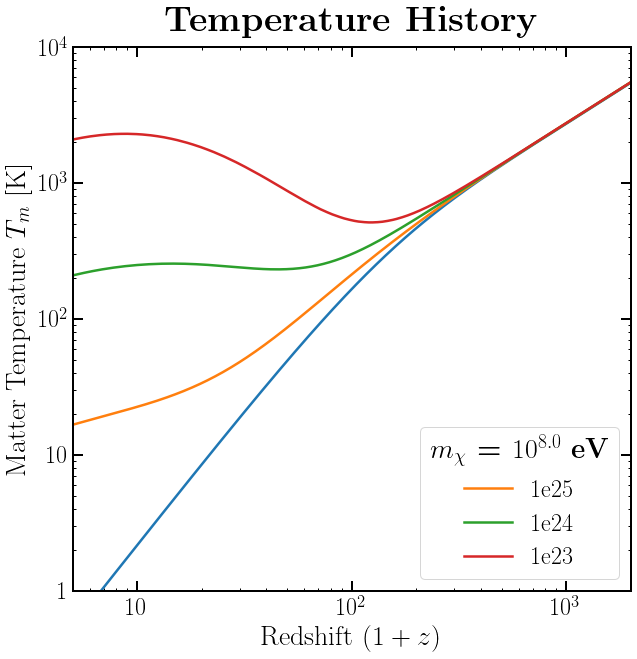

In [121]:
plt.figure()
plt_0, = plt.plot(soln[0,:], soln[2,:], label='None')
plt_3, = plt.plot(b3[3].rs, b3[0], label='1e25')
plt_2, = plt.plot(b2[3].rs, b2[0], label='1e24')
plt_1, = plt.plot(b1[3].rs, b1[0], label='1e23')

ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
plt.title(r'\bf{Ionization History}')
plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel(r'Electron Fraction $x_e$ [K]')
leg = plt.legend(handles=[plt_3, plt_2, plt_1],
                 title=r'$m_\chi$\bf{ = $10^{'+str(np.log10(mDM))+'}$ eV}',
                 loc=2
                )
plt.setp(leg.get_title(),fontsize=28)
plt.axis([5, 2e3, 1e-4, 1])
#plt.savefig('/home/gridgway/Desktop/xe_decay_comparison.png')

plt.figure()
plt_T0, = plt.plot(soln[0,:], soln[1,:]/phys.kB, label='None')
plt_T3, = plt.plot(b3[3].rs, b3[1]/phys.kB, label='1e25')
plt_T2, = plt.plot(b2[3].rs, b2[1]/phys.kB, label='1e24')
plt_T1, = plt.plot(b1[3].rs, b1[1]/phys.kB, label='1e23')

# plt.plot(b[3].rs, phys.TCMB(b[3].rs)/phys.kB, 'k:')
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
plt.title(r'\bf{Temperature History}')
plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel(r'Matter Temperature $T_m$ [K]')
leg2 = plt.legend(handles=[plt_T3, plt_T2, plt_T1],
                  title=r'$m_\chi$\bf{ = $10^{'+str(np.log10(mDM))+'}$ eV}',
                  loc=4
                 )
plt.setp(leg2.get_title(),fontsize=28)
plt.axis([5, 2e3, 1, 1e4])
#plt.savefig('/home/gridgway/Desktop/Tm_decay_comparison.png')

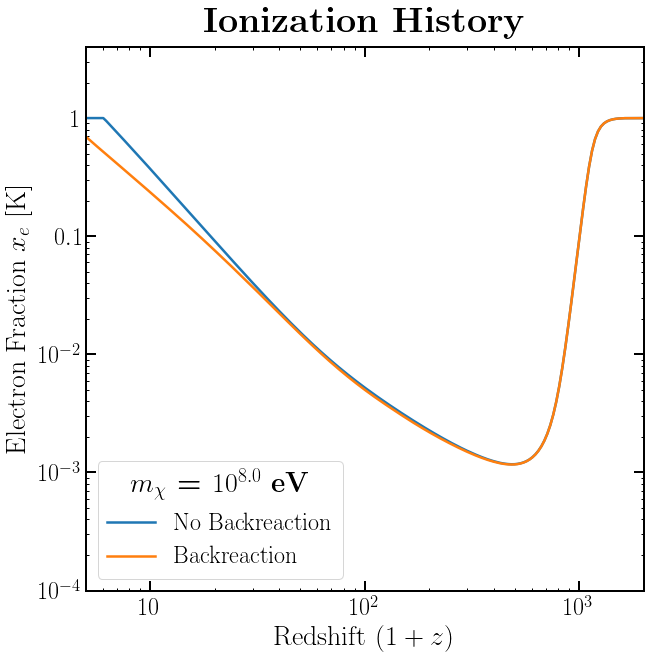

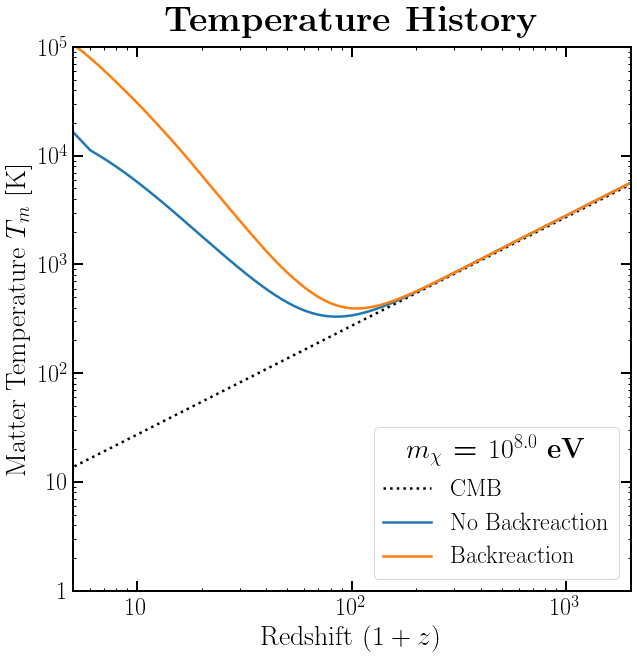

In [144]:
plt.figure()
plt_xe_std, = plt.plot(a[3].rs, a[0], label='No Backreaction')
plt_xe_backReact, = plt.plot(b[3].rs, b[0], label='Backreaction')
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
plt.title(r'\bf{Ionization History}')
plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel(r'Electron Fraction $x_e$ [K]')
leg = plt.legend(handles=[plt_xe_std, plt_xe_backReact],
                 title=r'$m_\chi$\bf{ = $10^{'+str(np.log10(mDM))+'}$ eV}',
                 loc=3
                )
plt.setp(leg.get_title(),fontsize=28)
plt.axis([5, 2e3, 1e-4, 4])
plt.savefig('/home/gridgway/Desktop/xe_elec.png')

plt.figure()
plt_TCMB, = plt.plot(a[3].rs, phys.TCMB(a[3].rs)/phys.kB, 'k:', label='CMB')
plt_Tm_std, = plt.plot(a[3].rs, a[1]/phys.kB, label='No Backreaction')
plt_Tm_backReact, = plt.plot(b[3].rs, b[1]/phys.kB, label='Backreaction')

# plt.plot(b[3].rs, phys.TCMB(b[3].rs)/phys.kB, 'k:')
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
plt.title(r'\bf{Temperature History}')
plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel(r'Matter Temperature $T_m$ [K]')
leg2 = plt.legend(handles=[plt_TCMB, plt_Tm_std, plt_Tm_backReact],
                  title=r'$m_\chi$\bf{ = $10^{'+str(np.log10(mDM))+'}$ eV}',
                  loc=4
                 )
plt.setp(leg2.get_title(),fontsize=28)
plt.axis([5, 2e3, 1, 1e5])
plt.savefig('/home/gridgway/Desktop/Tm_elec.png')

## Generate $f_c(z)$ contour plots

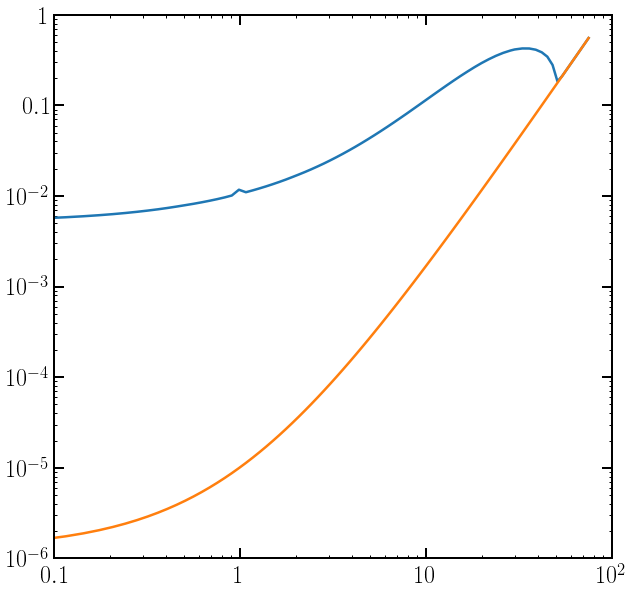

In [151]:
plt.figure()
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
plt.plot(struct_data[:,0]-1, [np.sqrt(struct_boost(rs))*phys.rho_DM*rs**3*1e-9 for rs in struct_data[:,0]])
plt.plot(struct_data[:,0]-1, [phys.rho_DM*rs**3*1e-9 for rs in struct_data[:,0]])
plt.axis([1e-1, 1e2, 1e-6, 1])
plt.show()

In [101]:
fz_elec_decay = np.loadtxt('/home/gridgway/Dropbox (MIT)/21cm_pwave/TLA_code/fz_electron_decay.dat', delimiter=',')

log10rs  = fz_elec_decay[0:70, 1]
log10eng = fz_elec_decay[0:2800:70, 0]

struct_data = np.loadtxt(open(cwd+"/../structure_formation_data/boost_Einasto_subs.txt", "rb"))
log_struct_interp = interp1d(np.log(struct_data[:,0]), np.log(struct_data[:,1]))
def struct_boost(rs):
    if rs<76:
        return np.exp(log_struct_interp(np.log(rs)))
    else:
        return 1

def rate_func_decay_N(rs):
    return phys.inj_rate(inj_type, rs, mDM=mDM, sigmav=sigmav, tau=tau)/Ecom
def rate_func_decay_eng(rs):
    return phys.inj_rate(inj_type, rs, mDM=mDM, sigmav=sigmav, tau=tau) 

def rate_func_swave_N(rs):
    return phys.inj_rate(inj_type, rs, mDM=mDM, sigmav=sigmav, tau=tau)*struct_boost(rs)/Ecom
def rate_func_swave_eng(rs):
    return phys.inj_rate(inj_type, rs, mDM=mDM, sigmav=sigmav, tau=tau)*struct_boost(rs) 

In [12]:
%autoreload
end_rs = 5
sigmav = 3e-26#1e-26
f_decay_phot = []
for i,mDM in enumerate(tqdm(10**log10eng)):
    Ecom=mDM
    tau=1e24
    phot_spec_init = spectools.rebin_N_arr(np.array([2]), 
                                      np.array([mDM/2]), 
                                      highengphot_tf_interp.eng)
    phot_spec_init.rs = 3000
    phot_spec_init.switch_spec_type()
    elec_spec_init = 0*phot_spec_init

    data_phot = main.evolve(
        elec_spec_init, phot_spec_init,
        rate_func_decay_N, rate_func_decay_eng, end_rs,
        highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp,
        #ics_thomson_ref_tf, ics_rel_ref_tf, engloss_ref_tf,
        coarsen_factor=4, std_soln=True,
        struct_boost=struct_boost,
        reion_switch=False
    )
    
    f_decay_phot.append(data_phot[5])

rs_list_phot = data_phot[3].rs
f_decay_phot = np.array(f_decay_phot)

pickle.dump(f_decay_phot, open("/home/gridgway/Dropbox (MIT)/Photon Deposition/f_decay_phot.p", "wb"))
pickle.dump(rs_list_phot, open("/home/gridgway/Dropbox (MIT)/Photon Deposition/rs_list_phot.p", "wb"))

NameError: name 'diff_list' is not defined

In [38]:
%autoreload
end_rs = 5
sigmav = 3e-27#1e-26
f_decay_elec = []
for i,mDM in enumerate(tqdm(10**log10eng[9:])):
    Ecom=mDM
    tau=1e26
    elec_spec_init = spectools.rebin_N_arr(np.array([2]), 
                                      np.array([mDM/2-phys.me]), 
                                      highengphot_tf_interp.eng)
    elec_spec_init.rs = 3000
    elec_spec_init.switch_spec_type()
    phot_spec_init = 0*elec_spec_init
    
    data_elec = main.evolve(
        elec_spec_init, phot_spec_init,
        rate_func_decay_N, rate_func_decay_eng, end_rs,
        highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp,
        ics_thomson_ref_tf, ics_rel_ref_tf, engloss_ref_tf,
        coarsen_factor=16, std_soln=True,
        reion_switch=False
    )
    
    f_decay_elec.append(data_elec[5])

rs_list_elec = data_elec[3].rs
f_decay_elec = np.array(f_decay_elec)

pickle.dump(f_decay_elec, open("/home/gridgway/Dropbox (MIT)/Photon Deposition/f_decay_elec.p", "wb"))

/home/gridgway/anaconda3/lib/python3.6/site-packages/scipy/integrate/odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


In [104]:
highengphot_tf_interp.eng

array([1.03931104e-04, 1.12262993e-04, 1.21262829e-04, 1.30984159e-04,
       1.41484823e-04, 1.52827298e-04, 1.65079070e-04, 1.78313035e-04,
       1.92607933e-04, 2.08048817e-04, 2.24727556e-04, 2.42743387e-04,
       2.62203501e-04, 2.83223683e-04, 3.05928998e-04, 3.30454541e-04,
       3.56946233e-04, 3.85561696e-04, 4.16471187e-04, 4.49858613e-04,
       4.85922622e-04, 5.24877791e-04, 5.66955896e-04, 6.12407295e-04,
       6.61502415e-04, 7.14533365e-04, 7.71815671e-04, 8.33690151e-04,
       9.00524950e-04, 9.72717723e-04, 1.05069801e-03, 1.13492977e-03,
       1.22591417e-03, 1.32419256e-03, 1.43034968e-03, 1.54501714e-03,
       1.66887720e-03, 1.80266680e-03, 1.94718197e-03, 2.10328255e-03,
       2.27189731e-03, 2.45402948e-03, 2.65076273e-03, 2.86326757e-03,
       3.09280838e-03, 3.34075088e-03, 3.60857031e-03, 3.89786012e-03,
       4.21034156e-03, 4.54787383e-03, 4.91246520e-03, 5.30628492e-03,
       5.73167616e-03, 6.19116992e-03, 6.68750012e-03, 7.22361983e-03,
      

In [133]:
%autoreload
mDM=2.88978347e+12
Ecom=2*mDM
phot_spec_init = spectools.rebin_N_arr(np.array([2]), 
                                  np.array([mDM]), 
                                  highengphot_tf_interp.eng)
phot_spec_init.rs = 3000
phot_spec_init.switch_spec_type()
elec_spec_init = 0*phot_spec_init

data_phot = main.evolve(
    elec_spec_init, phot_spec_init,
    rate_func_swave_N, rate_func_swave_eng, end_rs,
    highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp,
    ics_thomson_ref_tf, ics_rel_ref_tf, engloss_ref_tf,
    coarsen_factor=4, std_soln=True,
    struct_boost=struct_boost,
    reion_switch=False
)

75.66892450568133 1.0000000829618856 1.0000000829618856 
 [0.09090931 0.00393312 0.0722387  0.04951026 0.38700014] 
 [0.0909093  0.00393312 0.07223869 0.04951025 0.38700011]
75.06598807103204 1.000000234984269 1.000000234984269 
 [0.09071017 0.00392867 0.07210277 0.04938865 0.38404612] 
 [0.09071015 0.00392867 0.07210275 0.04938863 0.38404603]
74.46785588524186 1.0000003870066756 1.0000003870066756 
 [0.09049966 0.00392375 0.07195793 0.04926105 0.3810193 ] 
 [0.09049962 0.00392375 0.0719579  0.04926103 0.38101915]
73.87448966764676 1.0000005390291051 1.0000005390291051 
 [0.09027755 0.00391835 0.071804   0.04912739 0.37791866] 
 [0.0902775  0.00391835 0.07180396 0.04912736 0.37791845]
73.28585144260626 1.000000691051558 1.000000691051558 
 [0.09004359 0.00391247 0.0716408  0.04898751 0.37474309] 
 [0.09004353 0.00391247 0.07164075 0.04898747 0.37474284]
72.70190353707305 1.000000966677187 1.000000966677187 
 [0.08991645 0.00391134 0.07156241 0.04890404 0.37225831] 
 [0.08991636 0.00391

51.12980358746489 1.5134315090917254 1.5134315090917254 
 [0.08605793 0.0039348  0.06939874 0.04609863 0.28218732] 
 [0.05686279 0.00259992 0.04585522 0.03045967 0.1864553 ]
50.72239695811561 1.7763741748129496 1.7763741748129496 
 [0.0859692  0.00393524 0.06934691 0.04603338 0.28025443] 
 [0.04839589 0.00221532 0.03903846 0.02591424 0.15776768]
50.318236579484925 2.085000338625261 2.085000338625261 
 [0.08587185 0.00393527 0.06928799 0.04596354 0.27827464] 
 [0.04118553 0.00188742 0.03323165 0.02204486 0.13346503]
49.91729658517066 2.447247023575544 2.447247023575544 
 [0.08576595 0.00393489 0.06922203 0.04588916 0.27624774] 
 [0.03504589 0.00160788 0.02828567 0.01875134 0.11288102]
49.51955131487632 2.8724302262455272 2.8724302262455272 
 [0.08565167 0.00393411 0.06914912 0.04581026 0.27417359] 
 [0.02981854 0.00136961 0.02407339 0.01594826 0.09545004]
49.12497531276884 3.37148449877121 3.37148449877121 
 [0.08552915 0.00393292 0.06906934 0.04572696 0.2720521 ] 
 [0.0253684  0.001166

35.105842431148 60.57686818986811 60.57686818986811 
 [0.09008074 0.00427584 0.07310874 0.0470717  0.22300135] 
 [1.48704847e-03 7.05853569e-05 1.20687546e-03 7.77057285e-04
 3.68129554e-03]
34.82611608893988 63.568940456359165 63.56894045635917 
 [0.09035261 0.00428952 0.07332218 0.04718157 0.22225964] 
 [1.42133259e-03 6.74781984e-05 1.15342782e-03 7.42211006e-04
 3.49635594e-03]
34.54861863004879 66.70880009970585 66.70880009970585 
 [0.09062368 0.00430301 0.07353405 0.04729066 0.22149886] 
 [1.35849669e-03 6.45043971e-05 1.10231401e-03 7.08911792e-04
 3.32038436e-03]
34.27333229454265 70.00374677941245 70.00374677941245 
 [0.09089376 0.00431631 0.07374416 0.0473989  0.22071848] 
 [1.29841286e-03 6.16583111e-05 1.05343156e-03 6.77090852e-04
 3.15295236e-03]
34.000239464002014 73.46144070694666 73.46144070694666 
 [0.09116243 0.00432941 0.07395222 0.0475061  0.21991777] 
 [1.24095625e-03 5.89344357e-05 1.00668077e-03 6.46680731e-04
 2.99364897e-03]
33.72932266039251 76.72650289561015

24.49251517099184 351.74534161579714 351.74534161579714 
 [0.11442813 0.00531886 0.09157697 0.0578181  0.2161005 ] 
 [3.25315281e-04 1.51213386e-05 2.60350200e-04 1.64374886e-04
 6.14366347e-04]
24.297356724254794 363.0401135340879 363.0401135340879 
 [0.11533582 0.0053553  0.09225758 0.05823219 0.21667285] 
 [3.17694413e-04 1.47512600e-05 2.54125026e-04 1.60401538e-04
 5.96828939e-04]
24.103753316641612 374.6975679319818 374.6975679319818 
 [0.11624477 0.00539159 0.092938   0.05864658 0.21723515] 
 [3.10236267e-04 1.43891829e-05 2.48034691e-04 1.56517112e-04
 5.79761302e-04]
23.91169255746813 386.7293507800187 386.7293507800187 
 [0.11715431 0.00542772 0.09361776 0.05906087 0.217786  ] 
 [3.02936182e-04 1.40349224e-05 2.42075649e-04 1.52718872e-04
 5.63148365e-04]
23.7211621547802 399.1474820084346 399.1474820084346 
 [0.11806345 0.00546364 0.09429619 0.05947459 0.21832375] 
 [2.95789026e-04 1.36882809e-05 2.36243975e-04 1.49004049e-04
 5.46975140e-04]
23.532149914567018 411.964367515

17.087848000736575 1268.9104482063203 1268.9104482063203 
 [0.14833463 0.00683186 0.11798965 0.07337051 0.23666048] 
 [1.16899207e-04 5.38403579e-06 9.29850095e-05 5.78216650e-05
 1.86506840e-04]
16.95169057261534 1301.7309786137844 1301.7309786137844 
 [0.14804061 0.0068339  0.11785059 0.07323304 0.2359721 ] 
 [1.13725967e-04 5.24985834e-06 9.05337489e-05 5.62581992e-05
 1.81275630e-04]
16.816618058476944 1335.400416221712 1335.400416221712 
 [0.14836431 0.00685397 0.11813411 0.07337749 0.23583051] 
 [1.11100994e-04 5.13251970e-06 8.84634402e-05 5.49479288e-05
 1.76599097e-04]
16.682621813634377 1369.940718123 1369.940718123 
 [0.14880095 0.00687804 0.11849892 0.07357317 0.2357437 ] 
 [1.08618536e-04 5.02068737e-06 8.64993057e-05 5.37053665e-05
 1.72083139e-04]
16.549693262282226 1405.3744093335454 1405.3744093335454 
 [0.14924274 0.00690275 0.11886995 0.07377114 0.23562668] 
 [1.06194288e-04 4.91167759e-06 8.45824034e-05 5.24921620e-05
 1.67661144e-04]
16.417823896947837 1441.7245974

11.921787013614102 3706.2938539260754 3706.2938539260754 
 [0.16194328 0.00778526 0.13045782 0.07925253 0.2162672 ] 
 [4.36941279e-05 2.10055218e-06 3.51989948e-05 2.13832301e-05
 5.83513360e-05]
11.8267931993952 3790.393957216719 3790.393957216719 
 [0.16227033 0.00780704 0.13075007 0.07939087 0.21569886] 
 [4.28109395e-05 2.05969035e-06 3.44951133e-05 2.09452820e-05
 5.69067125e-05]
11.732556303977946 3876.4023893264557 3876.4023893264557 
 [0.16257821 0.00782786 0.13102671 0.07951988 0.21509626] 
 [4.19404894e-05 2.01936122e-06 3.38011110e-05 2.05138342e-05
 5.54886303e-05]
11.63907029616887 3964.362452448027 3964.362452448027 
 [0.16286651 0.0078477  0.13128738 0.07963935 0.21445883] 
 [4.10826483e-05 1.97956104e-06 3.31168959e-05 2.00888158e-05
 5.40966745e-05]
11.546329192831557 4054.3184313511106 4054.3184313511106 
 [0.16313476 0.00786654 0.13153171 0.07974907 0.21378597] 
 [4.02372837e-05 1.94028583e-06 3.24423727e-05 1.96701548e-05
 5.27304346e-05]
11.454327058503742 4146.315

8.317548563859614 10090.310784178348 10090.310784178348 
 [0.18396575 0.00911793 0.14948797 0.08892281 0.19981648] 
 [1.82319212e-05 9.03631919e-07 1.48150016e-05 8.81269334e-06
 1.98028072e-05]
8.251273628555895 10318.677686336248 10318.677686336248 
 [0.18457227 0.00915309 0.15000467 0.08919216 0.19957562] 
 [1.78872016e-05 8.87041343e-07 1.45371991e-05 8.64375864e-06
 1.93412007e-05]
8.185526777580845 10551.685655714295 10551.685655714295 
 [0.18515868 0.00918722 0.15050481 0.08945182 0.19930777] 
 [1.75477819e-05 8.70687075e-07 1.42635794e-05 8.47749121e-06
 1.88887134e-05]
8.120303803113561 10789.955221146027 10789.955221146027 
 [0.18572469 0.00922028 0.15098812 0.08970166 0.19901251] 
 [1.72127392e-05 8.54524226e-07 1.39933963e-05 8.31344154e-06
 1.84442386e-05]
8.055600530861412 11033.605195705137 11033.605195705137 
 [0.18626995 0.00925226 0.15145433 0.08994152 0.1986894 ] 
 [1.68820565e-05 8.38552787e-07 1.37266399e-05 8.15159823e-06
 1.80076592e-05]
7.991412819792888 11282.7

5.802956723950953 28243.155269059 28243.155269059 
 [0.21448031 0.01084755 0.17530191 0.10249128 0.19057482] 
 [7.59406319e-06 3.84077112e-07 6.20688128e-06 3.62888918e-06
 6.74764633e-06]
5.756718270577661 28921.431094518484 28921.431094518484 
 [0.21545859 0.01090094 0.17611976 0.1029332  0.19063765] 
 [7.44978997e-06 3.76915480e-07 6.08959345e-06 3.55906324e-06
 6.59157036e-06]
5.710848249138649 29615.996109022835 29615.99610902284 
 [0.21641428 0.01095313 0.1769189  0.10336436 0.19067777] 
 [7.30734418e-06 3.69838149e-07 5.97376143e-06 3.49015306e-06
 6.43833728e-06]
5.665343723936889 30327.241506935552 30327.241506935552 
 [0.21734751 0.01100412 0.17769941 0.10378481 0.19069499] 
 [7.16674193e-06 3.62846147e-07 5.85939910e-06 3.42216461e-06
 6.28791077e-06]
5.620201782667236 31055.56787738047 31055.56787738047 
 [0.21825825 0.01105392 0.17846124 0.10419453 0.19068902] 
 [7.02799080e-06 3.55940092e-07 5.74651362e-06 3.35509993e-06
 6.14025239e-06]
5.575419536230039 31801.3854298626

In [123]:
rate_func_swave_N(5)

1.9795002688110924e-36

In [115]:
struct_boost(10)

6053.046167404043

In [121]:
rate_func_decay_N(5)

4.4726971364921695e-41

In [109]:
Ecom=mDM
phot_spec_init = spectools.rebin_N_arr(np.array([2]), 
                                  np.array([mDM/2]), 
                                  highengphot_tf_interp.eng)
phot_spec_init.rs = 3000
phot_spec_init.switch_spec_type()
elec_spec_init = 0*phot_spec_init

data_decay = main.evolve(
    elec_spec_init, phot_spec_init,
    rate_func_decay_N, rate_func_decay_eng, end_rs,
    highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp,
    #ics_thomson_ref_tf, ics_rel_ref_tf, engloss_ref_tf,
    coarsen_factor=4, std_soln=True,
    reion_switch=False
)

In [119]:
data_phot[5]

array([[2.50151780e-03, 1.15842666e-17, 1.11451366e-03, 1.15842666e-02,
        3.98647307e-02],
       [6.88395020e-03, 3.06438117e-17, 3.24283952e-03, 3.06438117e-02,
        1.34308539e-01],
       [1.18714928e-02, 5.29281705e-17, 5.70811775e-03, 5.29281705e-02,
        2.58921255e-01],
       ...,
       [2.28119670e-01, 1.15932310e-02, 1.86708820e-01, 1.08600089e-01,
        1.89388199e-01],
       [2.29226999e-01, 1.16527045e-02, 1.87629540e-01, 1.09101849e-01,
        1.89529808e-01],
       [2.30310152e-01, 1.17108958e-02, 1.88530225e-01, 1.09592134e-01,
        1.89649308e-01]])

In [112]:
data_decay[5]

array([[2.52514424e-03, 1.16936678e-17, 1.12504134e-03, 1.16936678e-02,
        4.02413019e-02],
       [6.94903929e-03, 3.09334440e-17, 3.27350482e-03, 3.09334440e-02,
        1.35578261e-01],
       [1.19838086e-02, 5.34286783e-17, 5.76212573e-03, 5.34286783e-02,
        2.61370014e-01],
       ...,
       [1.69592630e-01, 9.27998237e-03, 1.42202514e-01, 8.05865958e-02,
        1.10404908e-01],
       [1.70521575e-01, 9.33025258e-03, 1.42976347e-01, 8.10073349e-02,
        1.10551547e-01],
       [1.71432478e-01, 9.37950226e-03, 1.43734920e-01, 8.14195262e-02,
        1.10685188e-01]])

In [39]:
%autoreload
end_rs = 5
sigmav = 3e-26#1e-26
tau=1e24
f_swave_phot = []
for i,mDM in enumerate(tqdm(10**log10eng)):
    Ecom=2*mDM
    phot_spec_init = spectools.rebin_N_arr(np.array([2]), 
                                      np.array([mDM]), 
                                      highengphot_tf_interp.eng)
    phot_spec_init.rs = 3000
    phot_spec_init.switch_spec_type()
    elec_spec_init = 0*phot_spec_init

    data_phot = main.evolve(
        elec_spec_init, phot_spec_init,
        rate_func_swave_N, rate_func_swave_eng, end_rs,
        highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp,
        ics_thomson_ref_tf, ics_rel_ref_tf, engloss_ref_tf,
        coarsen_factor=4, std_soln=True,
        reion_switch=False
    )
    
    f_swave_phot.append(data_phot[5])

rs_list_phot = data_phot[3].rs
f_swave_phot = np.array(f_swave_phot)

pickle.dump(f_swave_phot, open("/home/gridgway/Dropbox (MIT)/Photon Deposition/f_swave_phot.p", "wb"))

/home/gridgway/anaconda3/lib/python3.6/site-packages/scipy/integrate/odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


OverflowError: the new abscissa lies below the old one: this function cannot handle overflow (yet?).

In [42]:
%autoreload
end_rs = 5
sigmav = 3e-26#1e-26
tau=1e24
f_swave_elec = []
for i,mDM in enumerate(tqdm(10**log10eng[9:])):
    Ecom=2*mDM
    elec_spec_init = spectools.rebin_N_arr(np.array([2]), 
                                      np.array([mDM-phys.me]), 
                                      highengphot_tf_interp.eng)
    elec_spec_init.rs = 3000
    elec_spec_init.switch_spec_type()
    phot_spec_init = 0*elec_spec_init
    
    data_elec = main.evolve(
        elec_spec_init, phot_spec_init,
        rate_func_swave_N, rate_func_swave_eng, end_rs,
        highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp,
        ics_thomson_ref_tf, ics_rel_ref_tf, engloss_ref_tf,
        coarsen_factor=16, std_soln=True,
        reion_switch=False
    )

    f_swave_elec.append(data_elec[5])

rs_list_elec = data_elec[3].rs
f_swave_elec = np.array(f_swave_elec)

pickle.dump(f_swave_elec, open("/home/gridgway/Dropbox (MIT)/Photon Deposition/f_swave_elec.p", "wb"))

/home/gridgway/anaconda3/lib/python3.6/site-packages/scipy/integrate/odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


OverflowError: the new abscissa lies below the old one: this function cannot handle overflow (yet?).

bonzai


FileNotFoundError: [Errno 2] No such file or directory: '/home/gridgway/.matplotlib/tex.cache/41e544265b7beb67169a2612cbaf5200.dvi'

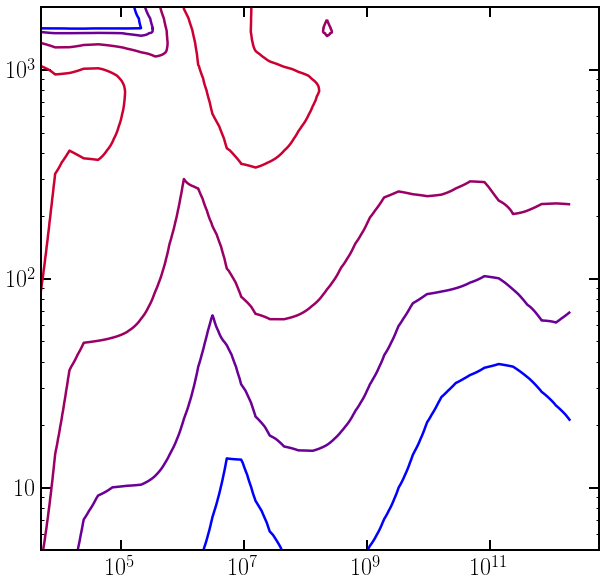

In [162]:
plt.figure()
inj_type='swave'
inj_particle='phot'
channel='H_ion'
fudge=1

if inj_particle is 'elec':
    engMin = 10**log10eng[9]
    coarsen_factor = 16

    if inj_type is 'decay':
        f_for_plot = f_decay_elec
        eng=10**log10eng[9:]
    elif inj_type is 'swave':
        f_for_plot = f_swave_elec
        eng=10**log10eng[9:-2]
else:
    engMin = 10**log10eng[0]
    coarsen_factor = 4

    if inj_type is 'decay':
        f_for_plot = f_decay_phot
        eng=10**log10eng
    elif inj_type is 'swave':
        f_for_plot = f_swave_phot
        eng=10**log10eng[:-2]
        coarsen_factor = 1
        fudge=2

rs_list = [3000*np.exp(-0.002*coarsen_factor*(i+1)) for i in np.arange(3200/coarsen_factor-fudge)]

if channel is 'H_ion':
    ind=0
    title = r'\bf{$f_{H ion}$}'
elif channel is 'He_ion':
    ind=1
    title = r'\bf{$f_{He ion}$}'
elif channel is 'exc':
    ind=2
    title = r'\bf{$f_{exc}$}'
elif channel is 'heat':
    ind=3
    title = r'\bf{$f_{heat}$}'
elif channel is 'cont':
    ind=4
    title = r'\bf{$f_{cont}$}'
    
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')

plt_heating = plt.contour(
    eng, rs_list, 
    np.transpose(np.log10(f_for_plot[:,:,ind])),
    levels=[-4, -3, -2, -1, 0],
    colors=[
        (0/256,0,256/256),
        (106/256,0,150/256),
        (156/256,0,100/256),
        (206/256,0,50/256), 
        (256/256,0,0/256)
    ]
)

plt.axis([engMin, 10**log10eng[-1], 5, 2e3])

if inj_type is 'decay':
    labels = { 
        -4:r'$10^{-4}$', 
        -3:r'$10^{-3}$',
        -2:r'$10^{-2}$',
        -1:r'$10^{-1}$',
        0:r'$1$'
    }
elif inj_type is 'swave':
    labels = { 
        -2:r'$10^{-2}$', 
        -1:r'$10^{-1}$',
        0:r'$1$',
        1:r'$10^{1}$',
        2:r'$10^{2}$'
    }

plt.clabel(
    plt_heating, inline=True, fontsize=16, rightside_up=True,
    fmt=labels
)

plt.title(title)
plt.ylabel(r'Redshift ($1+z$)')
plt.xlabel(r'Dark Matter Mass $m_\chi$ [eV]')

user='gridgway'
# plt.savefig(
#     '/home/gridgway/Dropbox (MIT)/Photon Deposition/plots/f_contours/f'+inj_particle+'_'+inj_type+'_'+channel+'_contour.pdf'
# )

# Comparison to old results

# Import $f(z)$

In [39]:
user = '/home/gridgway'
greg = ''

#---------- Decay ----------#
fz_elec_decay = np.loadtxt(user+'/Dropbox (MIT)/21cm_pwave/TLA_code/fz_electron_decay.dat', delimiter=',')

log10rs  = fz_elec_decay[0:70, 1]
log10eng = fz_elec_decay[0:2800:70, 0] 

log10f_elec_decay = {
    'H_ion':   np.transpose(np.reshape(fz_elec_decay[0:2800,2], (40,70))),
    'He_ion':  np.transpose(np.reshape(fz_elec_decay[2800:5600,2], (40,70))),
    'H_exc':   np.transpose(np.reshape(fz_elec_decay[5600:8400,2], (40,70))),
    'heating': np.transpose(np.reshape(fz_elec_decay[8400:11200,2], (40,70))),
    'cont':    np.transpose(np.reshape(fz_elec_decay[11200:14000,2], (40,70))) 
}

fz_phot_decay = np.loadtxt(user+'/Dropbox (MIT)/21cm_pwave/TLA_code/fz_photon_decay.dat', delimiter=',')

log10rs  = fz_phot_decay[0:70, 1]
log10eng = fz_phot_decay[0:2800:70, 0] 

log10f_phot_decay = {
    'H_ion':   np.transpose(np.reshape(fz_phot_decay[0:2800,2], (40,70))),
    'He_ion':  np.transpose(np.reshape(fz_phot_decay[2800:5600,2], (40,70))),
    'H_exc':   np.transpose(np.reshape(fz_phot_decay[5600:8400,2], (40,70))),
    'heating': np.transpose(np.reshape(fz_phot_decay[8400:11200,2], (40,70))),
    'cont':    np.transpose(np.reshape(fz_phot_decay[11200:14000,2], (40,70)))
}


#---------- s-wave ----------#
fz_elec_swave = np.loadtxt(user+'/Dropbox (MIT)/21cm_pwave/TLA_code/fz_electron_swave_NFW_no_subs.dat', delimiter=',')

log10rs  = fz_elec_swave[0:70, 1]
log10eng = fz_elec_swave[0:2800:70, 0] 

log10f_elec_swave = {
    'H_ion':   np.transpose(np.reshape(fz_elec_swave[0:2800,2], (40,70))),
    'He_ion':  np.transpose(np.reshape(fz_elec_swave[2800:5600,2], (40,70))),
    'H_exc':   np.transpose(np.reshape(fz_elec_swave[5600:8400,2], (40,70))),
    'heating': np.transpose(np.reshape(fz_elec_swave[8400:11200,2], (40,70))),
    'cont':    np.transpose(np.reshape(fz_elec_swave[11200:14000,2], (40,70))) 
}

fz_phot_swave = np.loadtxt(user+'/Dropbox (MIT)/21cm_pwave/TLA_code/fz_photon_swave_NFW_no_subs.dat', delimiter=',')

log10rs  = fz_phot_swave[0:70, 1]
log10eng = fz_phot_swave[0:2800:70, 0] 

log10f_phot_swave = {
    'H_ion':   np.transpose(np.reshape(fz_phot_swave[0:2800,2], (40,70))),
    'He_ion':  np.transpose(np.reshape(fz_phot_swave[2800:5600,2], (40,70))),
    'H_exc':   np.transpose(np.reshape(fz_phot_swave[5600:8400,2], (40,70))),
    'heating': np.transpose(np.reshape(fz_phot_swave[8400:11200,2], (40,70))),
    'cont':    np.transpose(np.reshape(fz_phot_swave[11200:14000,2], (40,70)))
}

#---------- p-wave ----------#
fz_elec_pwave = np.loadtxt(user+'/Dropbox (MIT)/21cm_pwave/TLA_code/fz_electron_pwave_NFW_no_subs'+
                           greg+'.dat', delimiter=',')

log10rs  = fz_elec_pwave[0:70, 1]
log10eng = fz_elec_pwave[0:2800:70, 0] 

log10f_elec_pwave = {
    'H_ion':   np.transpose(np.reshape(fz_elec_pwave[0:2800,2], (40,70))),
    'He_ion':  np.transpose(np.reshape(fz_elec_pwave[2800:5600,2], (40,70))),
    'H_exc':   np.transpose(np.reshape(fz_elec_pwave[5600:8400,2], (40,70))),
    'heating': np.transpose(np.reshape(fz_elec_pwave[8400:11200,2], (40,70))),
    'cont':    np.transpose(np.reshape(fz_elec_pwave[11200:14000,2], (40,70))) 
}

fz_phot_pwave = np.loadtxt(user+'/Dropbox (MIT)/21cm_pwave/TLA_code/fz_photon_pwave_NFW_no_subs'+
                           greg+'.dat', delimiter=',')

log10rs  = fz_phot_pwave[0:70, 1]
log10eng = fz_phot_pwave[0:2800:70, 0] 

log10f_phot_pwave = {
    'H_ion':   np.transpose(np.reshape(fz_phot_pwave[0:2800,2], (40,70))),
    'He_ion':  np.transpose(np.reshape(fz_phot_pwave[2800:5600,2], (40,70))),
    'H_exc':   np.transpose(np.reshape(fz_phot_pwave[5600:8400,2], (40,70))),
    'heating': np.transpose(np.reshape(fz_phot_pwave[8400:11200,2], (40,70))),
    'cont':    np.transpose(np.reshape(fz_phot_pwave[11200:14000,2], (40,70)))
}


# Heating Processes

In [40]:
def compton_cooling_rate(xe, T_matter, rs):
    """Returns the Compton cooling rate. 

    Parameters
    ----------
    xe : float
        The ionization fraction ne/nH. 
    T_matter : float
        The matter temperature in eV. 
    rs : float
        The redshift in 1+z. 

    Returns
    -------
    float
        The Compton cooling rate in eV/s. 
    """
    return (
        xe / (1 + xe + phys.nHe/phys.nH) * (phys.TCMB(rs) - T_matter)
        * 32 * phys.thomson_xsec * phys.stefboltz
        * phys.TCMB(rs)**4 / (3 * phys.me)
    )

# Ionization Processes

In [41]:
def alpha_recomb(T_matter):
    """Case-B recombination coefficient. 

    Parameters
    ----------
    T_matter : float
        The matter temperature. 

    Returns
    -------
    float
        Case-B recombination coefficient in cm^3/s. 
    """ 
    
    # Fudge factor recommended in 1011.3758
    fudge_fac = 1.126

    return (
        fudge_fac * 1e-13 * 4.309 * (1.16405*T_matter)**(-0.6166)
        / (1 + 0.6703 * (1.16405*T_matter)**0.5300)
    )

def beta_ion(T_rad):
    """Case-B photoionization coefficient. 

    Parameters
    ----------
    T_rad : float
        The radiation temperature. 

    Returns
    -------
    float
        Case-B photoionization coefficient in s^-1. 

    """
    reduced_mass = phys.mp*phys.me/(phys.mp + phys.me)
    de_broglie_wavelength = (
        phys.c * 2*np.pi*phys.hbar
        / np.sqrt(2 * np.pi * reduced_mass * T_rad)
    )
    return (
        (1/de_broglie_wavelength)**3/4 
        * np.exp(-phys.rydberg/4/T_rad) * alpha_recomb(T_rad)
    )

def peebles_C(xe, rs):
    """Returns the Peebles C coefficient. 

    This is the ratio of the total rate for transitions from n = 2 to the ground state to the total rate of all transitions, including ionization.

    Parameters
    ----------
    xe : float
        The ionization fraction ne/nH. 
    Tm : float
        The matter temperature. 
    rs : float
        The redshift in 1+z. 

    Returns
    -------
    float
        The Peebles C factor. 
    """

    # Net rate for 2p to 1s transition, times (1-xe). 
    rate_2p1s = (
        8 * np.pi * phys.hubble(rs)
        /(3*(phys.nH*rs**3 * (phys.c/phys.lya_freq)**3))
    )

    # Net rate for 2s to 1s transition, times (1-xe).
    rate_2s1s = phys.width_2s1s * (1-xe)

    # Net rate for ionization, times (1-xe).
    rate_ion = beta_ion(phys.TCMB(rs)) * (1-xe)

    # Rate is averaged over 3/4 of excited state being in 2p, 1/4 in 2s. 
    return (
        (3*rate_2p1s/4 + rate_2s1s/4)
        /(3*rate_2p1s/4 + rate_2s1s/4 + rate_ion)
    )

# TLA Differential Equation

In [42]:
import darkhistory.physics as phys
from scipy.integrate import odeint
from scipy.interpolate import interp1d
from scipy.interpolate import interp2d
from scipy.integrate import quad

def get_history(
    init_cond, f_H_ion, f_H_exc, f_heating, 
    dm_injection_rate, dm_injection_param, rs_vec
):
    """Returns the ionization and thermal history of the IGM. 

    Parameters
    ----------
    init_cond : array
        Array containing [initial temperature, initial xe]
    fz_H_ion : function
        f(xe, rs) for hydrogen ionization. 
    fz_H_exc : function
        f(xe, rs) for hydrogen Lyman-alpha excitation. 
    f_heating : function
        f(xe, rs) for heating. 
    dm_injection_rate : function
        Injection rate of DM as a function of redshift, and one parameter (lifetime or cross section). 
    dm_injection_param : float
        The injection parameter (lifetime or cross section).
    rs_vec : ndarray
        Abscissa for the solution. 

    Returns
    -------
    list of ndarray
        [temperature solution (in eV), xe solution]. 

    Note
    ----
    The actual differential equation that we solve is expressed in terms of y = arctanh(2*(xe - 0.5)). 

    """

    def tla_diff_eq(var, rs):
        # Returns an array of values for [dT/dz, dy/dz].
        # var is the [temperature, xe] inputs. 

        def xe(y):
            return 0.5 + 0.5*np.tanh(y)

        def dT_dz(T_matter, y, rs):
            #print(y)
            return (
                2*T_matter/rs - phys.dtdz(rs) * (
                    compton_cooling_rate(xe(y), T_matter, rs)
                    + (
                        1/(1 + xe(y) + phys.nHe/phys.nH)
                        * 2/(3 * phys.nH * rs**3)
                        * f_heating(rs, xe(y))
                        * dm_injection_rate(rs, dm_injection_param)
                    )
                )
            )

        def dy_dz(T_matter, y, rs):
            # Stops any change in y once it exceeds y = 4, or xe = 0.999665
            #print(rs, y)
            if y > 4 and rs < 100:
                return 0
            return (
                2 * np.cosh(y)**2 * phys.dtdz(rs) * (
                    peebles_C(xe(y), rs) * (
                        alpha_recomb(T_matter) * xe(y)**2 * phys.nH * rs**3
                        - (
                            beta_ion(phys.TCMB(rs)) * (1 - xe(y))
                            * np.exp(-phys.lya_eng/T_matter)
                        )
                    )
                    - (
                        f_H_ion(rs, xe(y)) * dm_injection_rate(rs, dm_injection_param)
                        / (phys.rydberg * phys.nH * rs**3)
                    )
                    - (1 - peebles_C(xe(y), rs)) * (
                        f_H_exc(rs, xe(y)) * dm_injection_rate(rs, dm_injection_param) 
                        / (phys.lya_eng * phys.nH * rs**3)
                    )
                )
            )

        T_matter, y = var[0], var[1]
        return [dT_dz(T_matter, y, rs), dy_dz(T_matter, y, rs)]

    mod_init_cond = np.array(init_cond)
    
    if mod_init_cond[1] == 1:
        mod_init_cond[1] = 1 - 1e-12
    
    mod_init_cond[1] = np.arctanh(2*(mod_init_cond[1] - 0.5))

    soln = odeint(tla_diff_eq, mod_init_cond, rs_vec)

    soln[:,1] = 0.5 + 0.5*np.tanh(soln[:,1])

    return soln

# TLA Full Solution

In [71]:
logmDM = 8
mDM = 10**logmDM
if np.log10(mDM) < 6:
    units = 'keV'
    mass = str(mDM/10**3)
elif np.log10(mDM) < 9:
    units = 'MeV'
    mass = str(mDM/10**6)
else:
    units = 'GeV'
    mass = str(int(mDM/10**9))

inj_type = 'decay'
#inj_param = 7e-29
prefactor = 1
exponent = -24
inj_param = prefactor * 10**exponent
#[-30.5, -30, -28.5, -27, -25.5]

# Set all of the fractions and DM injection functions.

def f_0(rs, xe):
    return np.zeros_like(rs)

def f_H_ion(rs, xe):
    if inj_type == 'decay':
        interp_func = interp2d(log10eng, log10rs, log10f_phot_decay['H_ion'])
    elif inj_type == 'swave':
        interp_func = interp2d(log10eng, log10rs, log10f_phot_swave['H_ion'])
    elif inj_type == 'pwave':
        interp_func = interp2d(log10eng, log10rs, log10f_phot_pwave['H_ion'])
    return 10**interp_func(np.log10(mDM - phys.me), np.log10(rs))[0]

def f_H_exc(rs, xe):
    if inj_type == 'decay':
        interp_func = interp2d(log10eng, log10rs, log10f_phot_decay['H_exc'])
    elif inj_type == 'swave':
        interp_func = interp2d(log10eng, log10rs, log10f_phot_swave['H_exc'])
    elif inj_type == 'pwave':
        interp_func = interp2d(log10eng, log10rs, log10f_phot_pwave['H_exc'])
    return 10**interp_func(np.log10(mDM - phys.me), np.log10(rs))[0]

def f_heating(rs, xe):
    if inj_type == 'decay':
        interp_func = interp2d(log10eng, log10rs, log10f_phot_decay['heating'])
    elif inj_type == 'swave':
        interp_func = interp2d(log10eng, log10rs, log10f_phot_swave['heating'])
    elif inj_type == 'pwave':
        interp_func = interp2d(log10eng, log10rs, log10f_phot_pwave['heating'])
    return 10**interp_func(np.log10(mDM - phys.me), np.log10(rs))[0]

def dm_injection_rate(rs, param):
    if inj_type == 'decay':
        return phys.rho_DM*rs**3/param
    elif inj_type == 'swave':
        return phys.rho_DM**2*rs**6*param/mDM
    elif inj_type == 'pwave':
        sigma_1D_B = 1e-11*phys.c*(1/100)**0.5
        return phys.rho_DM**2*rs**8*param/mDM*(sigma_1D_B/1e7)**2

rs_start = 3000
init_cond = [phys.TCMB(rs_start), 1]
rs_vec = np.flipud(1 + np.arange(0,rs_start-0.5,0.5))


inj_type = 'decay'
inj_param = 1e24

soln = get_history(init_cond, f_0, f_0, f_0, dm_injection_rate, inj_param, rs_vec)
soln_dec = get_history(init_cond, f_H_ion, f_H_exc, f_heating, dm_injection_rate, inj_param, rs_vec)

[10, 2000.0, 1, 20000.0]

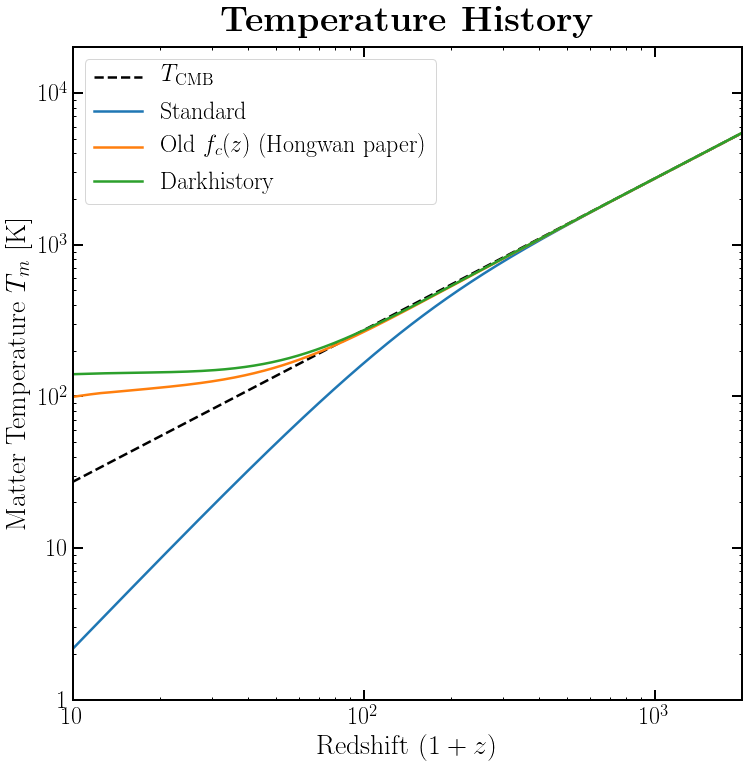

In [86]:
matplotlib.rcParams['figure.figsize'] = [12,12]
plt.figure()

ax = plt.gca()

T_CMB, = plt.plot(rs_vec, phys.TCMB(rs_vec)/phys.kB, 'k--', label=r'$T_\mathrm{CMB}$')
T_IGM_std, = plt.plot(std_soln_rs, std_soln_T, label='Standard')
T_IGM_dec, = plt.plot(rs_vec, soln_dec[:,0]/phys.kB, alpha=1.0, label=r'Old $f_c(z)$ (Hongwan paper)')
plt_Tm_std, = plt.plot(a[3].rs, a[1]/phys.kB, label='Darkhistory')

ax.set_xscale('log')
ax.set_yscale('log')

leg = plt.legend(handles=[T_CMB, T_IGM_std, T_IGM_dec, plt_Tm_std], 
                 #title=r'$m_\chi$\bf{ = '+mass+' '+units+' }',#$(1+z)_\mathrm{td} = 500$',
                 loc=2
                )
plt.setp(leg.get_title(),fontsize=28)

plt.title(r'\bf{Temperature History}')
plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel(r'Matter Temperature $T_m$ [K]')
plt.axis([10, 2e3, 1, 2e4])

# plt.savefig('/Users/'+user+'/Dropbox (MIT)/21cm_pwave/plots/T_standard_dec_swave_pwave_constraint.pdf')

# TeVPA Plotting

In [18]:
#Download tau_min and sigma_max

user = 'gridgway'
f_elec_CMB_raw = np.loadtxt('/Users/'+user+'/Dropbox (MIT)/21cm_pwave/TLA_code/fFromIonBaseline3keV_electron_extended.dat', delimiter=',')
log10eng_elec_CMB  = f_elec_CMB_raw[0:2760:69, 0]
log10rs_elec_CMB = f_elec_CMB_raw[0:69, 1] 

f_phot_CMB_raw = np.loadtxt('/Users/'+user+'/Dropbox (MIT)/21cm_pwave/TLA_code/fFromIonBaseline3keV_photon.dat', delimiter=',')
log10eng_phot_CMB  = f_phot_CMB_raw[0:2800:70, 0]
log10rs_phot_CMB = f_phot_CMB_raw[0:70, 1] 

f_elec_CMB_raw = np.transpose(np.reshape(f_elec_CMB_raw[:,2], (40,69)))
f_phot_CMB_raw = np.transpose(np.reshape(f_phot_CMB_raw[:,2], (40,70)))

f_elec_CMB = interp2d(log10eng_elec_CMB, log10rs_elec_CMB, f_elec_CMB_raw)
f_phot_CMB = interp2d(log10eng_phot_CMB, log10rs_phot_CMB, f_phot_CMB_raw)

decay_elec_CMB_raw = np.loadtxt('/Users/'+user+'/Dropbox (MIT)/21cm_pwave/TLA_code/CMB_limits_elec_decay.csv', delimiter=',')
decay_phot_CMB_raw = np.loadtxt('/Users/'+user+'/Dropbox (MIT)/21cm_pwave/TLA_code/CMB_limits_phot_decay.csv', delimiter=',')

decay_elec_CMB = interp1d(np.transpose(decay_elec_CMB_raw)[0,:], np.transpose(decay_elec_CMB_raw)[1,:])
decay_phot_CMB = interp1d(np.transpose(decay_phot_CMB_raw)[0,:], np.transpose(decay_phot_CMB_raw)[1,:])

def max_xsec_elec_CMB(mDM, injection_type):
    if injection_type == 'swave':
        return 4.1e-28*(mDM*1e-9)/f_elec_CMB(np.log10(mDM-phys.me), np.log10(601))
    elif injection_type == 'decay':
        return decay_elec_CMB(mDM*1e-9)

def max_xsec_phot_CMB(mDM, injection_type):
    if injection_type == 'swave':
        return 4.1e-28*(mDM*1e-9)/f_phot_CMB(np.log10(mDM), np.log10(601))
    elif injection_type == 'decay':
        return decay_phot_CMB(mDM*1e-9)

### Single Temperature History

In [39]:
%autoreload
global user 
user = "gridgway"
end_rs = 5
mDM = 1e8
sigmav = max_xsec_phot_CMB(mDM, 'swave')
tau = max_xsec_phot_CMB(mDM, 'decay')


phot_spec_init = spectools.rebin_N_arr(np.array([2]), 
                                      np.array([mDM/2]), 
                                      highengphot_tf_interp.eng)
phot_spec_init.rs = 3000
phot_spec_init.switch_spec_type()

def rate_func_swave_N(rs):
    # This is dN/dV dt
    return phys.inj_rate('swave', rs, mDM=mDM, sigmav=sigmav)/(2*mDM)

def rate_func_swave_eng(rs):
    # This is dN/dV dt
    return phys.inj_rate('swave', rs, mDM=mDM, sigmav=sigmav)

def rate_func_decay_N(rs):
    # This is dN/dV dt
    return phys.inj_rate('decay', rs, tau=tau)/mDM

def rate_func_decay_eng(rs):
    # This is dN/dV dt
    return phys.inj_rate('decay', rs, tau=tau)


def rate_func_swave_N_2(rs):
    # This is dN/dV dt
    return phys.inj_rate('swave', rs, mDM=mDM, sigmav=sigmav*1e-30)/(2*mDM)

def rate_func_swave_eng_2(rs):
    # This is dN/dV dt
    return phys.inj_rate('swave', rs, mDM=mDM, sigmav=sigmav*1e-30)

#!!! What about Reionization
std_data = main.evolve(
    phot_spec_init*0, phot_spec_init,
    rate_func_decay_N, rate_func_decay_eng, end_rs,
    highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp,
    xe_init=xe_std(phot_spec_init.rs), Tm_init=phys.TCMB(phot_spec_init.rs), 
    coarsen_factor=1, std_soln=True, user="gridgway"
)

backReact_data = main.evolve(
    phot_spec_init*0, phot_spec_init,
    rate_func_decay_N, rate_func_decay_eng, end_rs,
    highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp,
    xe_init=xe_std(phot_spec_init.rs), Tm_init=phys.TCMB(phot_spec_init.rs), 
    coarsen_factor=1, std_soln=False, user="gridgway"
)

../darkhistory/spec/spectrum.py:758: RuntimeWarning: The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.
  warnings.warn("The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.", RuntimeWarning)
../darkhistory/spec/spectrum.py:663: RuntimeWarning: divide by zero encountered in log
  np.log(bound_arr),


[None, None]

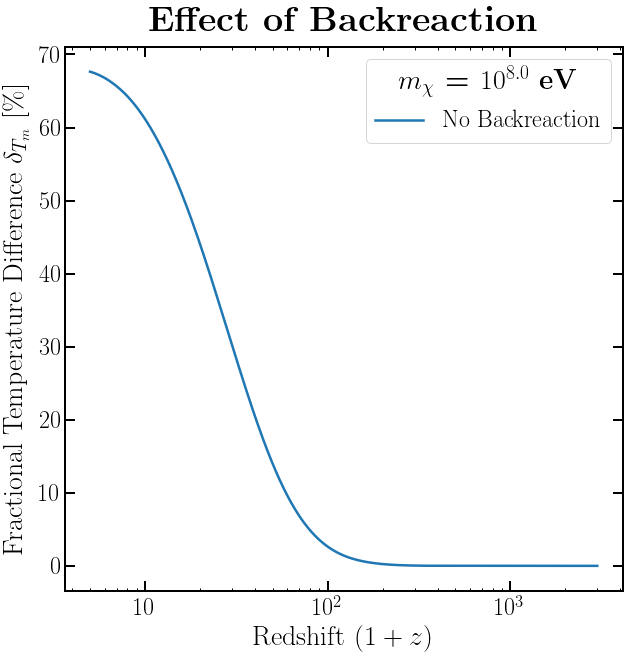

In [50]:
plt.figure()
plt_Tm_diff, = plt.plot(
    std_data[3].rs, np.abs((std_data[1]-backReact_data[1])/std_data[1] * 100), 
    label='No Backreaction'
)

ax = plt.gca()
ax.set_xscale('log')
#ax.set_yscale('log')

plt.title(r'\bf{Effect of Backreaction}')
plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel(r'Fractional Temperature Difference $\delta_{T_m}$ [\%]')
leg2 = plt.legend(handles=[plt_Tm_diff],
                  title=r'$m_\chi$\bf{ = $10^{'+str(np.log10(mDM))+'}$ eV}',
                  loc=1
                 )
plt.setp(leg2.get_title(),fontsize=28)

### rs vs. mDM heat plot of differences

In [62]:
%autoreload

fz_phot_decay = np.loadtxt('/Users/'+user+'/Dropbox (MIT)/21cm_pwave/TLA_code/fz_photon_decay.dat', delimiter=',')
log10eng = fz_phot_decay[0:2800:70, 0]

end_rs = 5

diff_list = []

log10eng = log10eng[2:]

for i,mDM in enumerate(tqdm(10**log10eng)):
    sigmav = max_xsec_phot_CMB(mDM, 'swave')
    tau = max_xsec_phot_CMB(mDM, 'decay')
    
    def rate_func_decay_N(rs):
        # This is dN/dV dt
        return phys.inj_rate('decay', rs, tau=tau)/mDM

    def rate_func_decay_eng(rs):
        # This is dN/dV dt
        return phys.inj_rate('decay', rs, tau=tau)
    
    phot_spec_init = spectools.rebin_N_arr(np.array([2]), 
                                      np.array([mDM/2]), 
                                      highengphot_tf_interp.eng)
    phot_spec_init.rs = 3000
    phot_spec_init.switch_spec_type()

    a = main.evolve(
        phot_spec_init*0, phot_spec_init,
        rate_func_decay_N, rate_func_decay_eng, end_rs,
        highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp,
        xe_init=xe_std(phot_spec_init.rs), Tm_init=phys.TCMB(phot_spec_init.rs), 
        coarsen_factor=1, std_soln=True, user="gridgway"
    )
    
    b = main.evolve(
        phot_spec_init*0, phot_spec_init,
        rate_func_decay_N, rate_func_decay_eng, end_rs,
        highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp,
        xe_init=xe_std(phot_spec_init.rs), Tm_init=phys.TCMB(phot_spec_init.rs), 
        coarsen_factor=1, std_soln=False, user="gridgway"
    )
    
    diff_list.append(np.abs((a[1]-b[1])/a[1] * 100))

rs_list = a[3].rs
diff_list = np.array(diff_list)

if(species=='elec'):
    pickle.dump(diff_list, open("/Users/gridgway/Dropbox (MIT)/Photon Deposition/backReact_elec_residuals.p", "wb"))
else:
    pickle.dump(diff_list, open("/Users/gridgway/Dropbox (MIT)/Photon Deposition/backReact_phot_residuals.p", "wb"))

../darkhistory/spec/spectrum.py:758: RuntimeWarning: The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.
  warnings.warn("The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.", RuntimeWarning)
../darkhistory/spec/spectrum.py:663: RuntimeWarning: divide by zero encountered in log
  np.log(bound_arr),


Text(0.5,0,'Dark Matter Mass $m_\\chi$ [eV]')

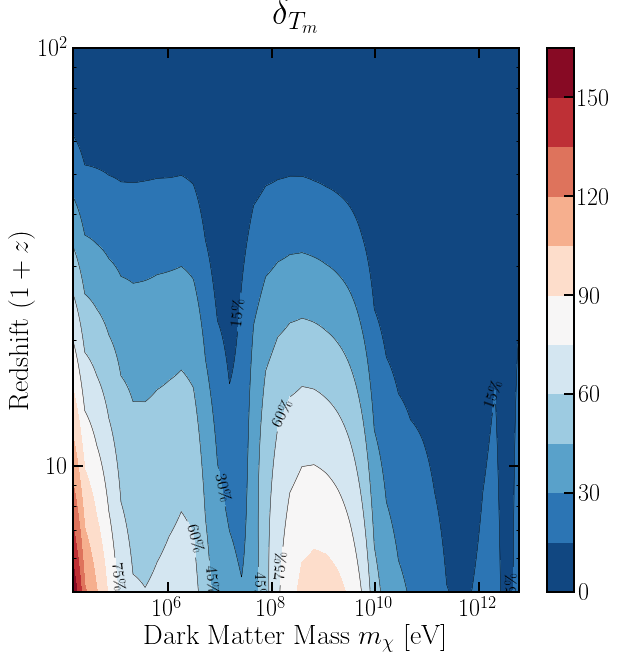

In [19]:
user = 'hongwan'

diff_list = pickle.load(open('/Users/'+user+'/Dropbox (MIT)/Photon Deposition/backReact_phot_residuals.p', "rb"))

rs_list = np.exp(np.arange(np.log(3000), np.log(5), step=-0.002))

fz_phot_decay = np.loadtxt('/Users/'+user+'/Dropbox (MIT)/21cm_pwave/TLA_code/fz_photon_decay.dat', delimiter=',')
log10eng = fz_phot_decay[0:2800:70, 0]
log10eng = log10eng[2:]


plt.figure()

ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')

plt_heating = plt.contour(
    10**log10eng, rs_list, 
    np.transpose(diff_list),
    levels=[15, 30, 45, 60, 75],
    linewidths=0.5,
    colors='k'
#     colors=[
#         (0/256,0,256/256),
#         (106/256,0,150/256),
#         (156/256,0,100/256),
#         (206/256,0,50/256), 
#         (256/256,0,0/256)
#     ]
)

plt.axis([10**log10eng[0], 10**log10eng[-1], 5, 100])

labels = { 
    15:r'$15$\%', 
    30:r'$30$\%',
    45:r'$45$\%',
    60:r'$60$\%',
    75:r'$75$\%'
}

plt.clabel(
    plt_heating, inline=True, fontsize=16, rightside_up=True,
    fmt=labels
)
cntr1 = ax.contourf(10**log10eng, rs_list, np.transpose(diff_list), 14, cmap="RdBu_r")
plt.colorbar(cntr1, ax=ax)

plt.title(r'\bf{$\delta_{T_m}$}')
plt.ylabel(r'Redshift ($1+z$)')
plt.xlabel(r'Dark Matter Mass $m_\chi$ [eV]')

# user='gridgway'
# plt.savefig('/Users/'+user+'/Dropbox (MIT)/Photon Deposition/plots/backReact_phot_residuals.pdf')

In [17]:
plt.figure()

ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')

plt_heating = plt.contour(
    10**log10eng, rs_list, 
    np.transpose(diff_list),
    levels=[15, 30, 45, 60, 75],
    linewidths=0.5,
    colors='k'
#     colors=[
#         (0/256,0,256/256),
#         (106/256,0,150/256),
#         (156/256,0,100/256),
#         (206/256,0,50/256), 
#         (256/256,0,0/256)
#     ]
)

plt.axis([10**log10eng[0], 10**log10eng[-1], 5, 100])

labels = { 
    15:r'$15$\%', 
    30:r'$30$\%',
    45:r'$45$\%',
    60:r'$60$\%',
    75:r'$75$\%'
}

plt.clabel(
    plt_heating, inline=True, fontsize=16, rightside_up=True,
    fmt=labels
)
cntr1 = ax.contourf(10**log10eng, rs_list, np.transpose(diff_list), 14, cmap="RdBu_r")
plt.colorbar(cntr1, ax=ax)

plt.title(r'\bf{$\delta_{T_m}$}')
plt.ylabel(r'Redshift ($1+z$)')
plt.xlabel(r'Dark Matter Mass $m_\chi$ [eV]')

# user='gridgway'
# plt.savefig('/Users/'+user+'/Dropbox (MIT)/Photon Deposition/plots/backReact_phot_residuals.pdf')

(3199,)

# Coarsening

In [57]:
%%prun

a1 = main.evolve(
    elec_spec_init, phot_spec_init,
    rate_func_N, rate_func_eng, 
    end_rs,
    highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp, 
    coarsen_factor=1, std_soln=std_soln
)
print("coarsen 1")

../darkhistory/spec/spectrum.py:758: RuntimeWarning: The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.
  warnings.warn("The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.", RuntimeWarning)
../darkhistory/spec/spectrum.py:663: RuntimeWarning: divide by zero encountered in log
  np.log(bound_arr),


coarsen 1
 

In [59]:
74.2/24.7

3.0040485829959516

In [62]:
%%prun

a16 = main.evolve(
    elec_spec_init, phot_spec_init,
    rate_func_N, rate_func_eng, 
    end_rs,
    highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp, 
    coarsen_factor=4, std_soln=std_soln
)
print("coarsen 16")

../darkhistory/spec/spectrum.py:758: RuntimeWarning: The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.
  warnings.warn("The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.", RuntimeWarning)
../darkhistory/spec/spectrum.py:663: RuntimeWarning: divide by zero encountered in log
  np.log(bound_arr),


coarsen 16
 

In [53]:
%autoreload
%time
end_rs = 5
std_soln=True

a1 = main.evolve(
    elec_spec_init, phot_spec_init,
    rate_func_N, rate_func_eng, 
    end_rs,
    highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp, 
    coarsen_factor=1, std_soln=std_soln
)
print("coarsen 1")

a2 = main.evolve(
    elec_spec_init, phot_spec_init,
    rate_func_N, rate_func_eng, 
    end_rs,
    highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp, 
    coarsen_factor=2, std_soln=std_soln
)
print("coarsen 2")

a4 = main.evolve(
    elec_spec_init, phot_spec_init,
    rate_func_N, rate_func_eng, 
    end_rs,
    highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp, 
    coarsen_factor=4, std_soln=std_soln
)
print("coarsen 4")

a8 = main.evolve(
    elec_spec_init, phot_spec_init,
    rate_func_N, rate_func_eng, 
    end_rs,
    highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp, 
    coarsen_factor=8, std_soln=std_soln
)
print("coarsen 8")

a16 = main.evolve(
    elec_spec_init, phot_spec_init,
    rate_func_N, rate_func_eng, 
    end_rs,
    highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp, 
    coarsen_factor=16, std_soln=std_soln
)
print("coarsen 16")

%time

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs


../darkhistory/spec/spectrum.py:758: RuntimeWarning: The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.
  warnings.warn("The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.", RuntimeWarning)
../darkhistory/spec/spectrum.py:663: RuntimeWarning: divide by zero encountered in log
  np.log(bound_arr),


coarsen 1
coarsen 2
coarsen 4
coarsen 8
coarsen 16
CPU times: user 8 µs, sys: 0 ns, total: 8 µs
Wall time: 4.77 µs


[None, None]

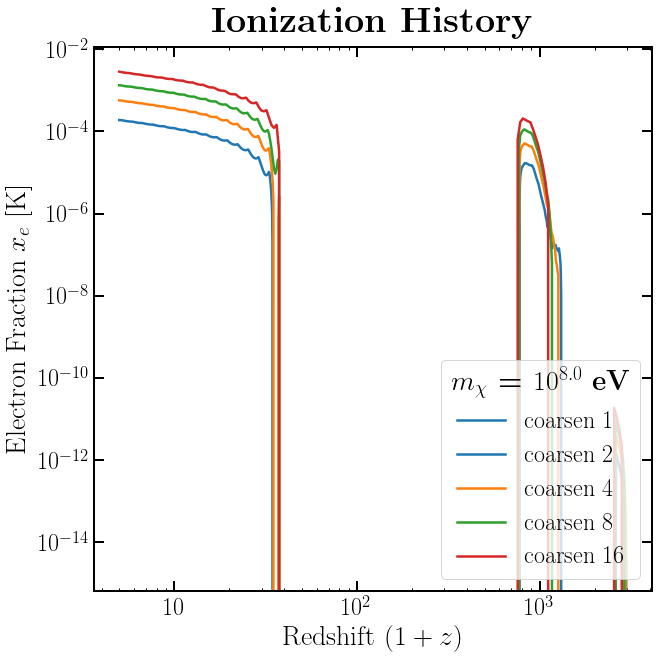

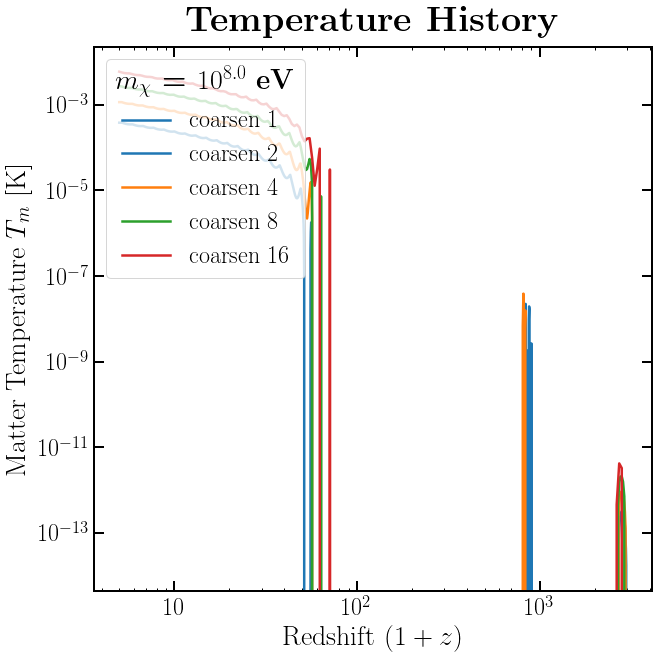

In [56]:
plt.figure()
#plt_1,  = plt.plot(a1[3].rs,  a1[0],  label='coarsen 1')
plt_2,  = plt.plot(a2[3].rs,  (a2[0]-a1[0][::2])/a2[0],  label='coarsen 2')
plt_4,  = plt.plot(a4[3].rs,  (a4[0]-a1[0][::4])/a4[0],  label='coarsen 4')
plt_8,  = plt.plot(a8[3].rs,  (a8[0]-a1[0][::8])/a8[0],  label='coarsen 8')
plt_16, = plt.plot(a16[3].rs, (a16[0]-a1[0][::16])/a16[0], label='coarsen 16')
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
plt.title(r'\bf{Ionization History}')
plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel(r'Electron Fraction $x_e$ [K]')
leg = plt.legend(handles=[plt_1, plt_2, plt_4, plt_8, plt_16],
                 title=r'$m_\chi$\bf{ = $10^{'+str(np.log10(mDM))+'}$ eV}',
                 loc=4
                )
plt.setp(leg.get_title(),fontsize=28)

plt.figure()
# plt_T1,  = plt.plot(a1[3].rs,  a1[1],  label='coarsen 1')
plt_T2,  = plt.plot(a2[3].rs,  (a2[1]-a1[1][::2])/a2[1],  label='coarsen 2')
plt_T4,  = plt.plot(a4[3].rs,  (a4[1]-a1[1][::4])/a4[1],  label='coarsen 4')
plt_T8,  = plt.plot(a8[3].rs,  (a8[1]-a1[1][::8])/a8[1],  label='coarsen 8')
plt_T16, = plt.plot(a16[3].rs, (a16[1]-a1[1][::16])/a16[1], label='coarsen 16')

# plt.plot(b[3].rs, phys.TCMB(b[3].rs)/phys.kB, 'k:')
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
plt.title(r'\bf{Temperature History}')
plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel(r'Matter Temperature $T_m$ [K]')
leg2 = plt.legend(handles=[plt_T1, plt_T2, plt_T4, plt_T8, plt_T16],
                  title=r'$m_\chi$\bf{ = $10^{'+str(np.log10(mDM))+'}$ eV}',
                  loc=2
                 )
plt.setp(leg2.get_title(),fontsize=28)

# Scratch Work

[20000.0, 1000000000000.0, 6e+22, 1e+31]

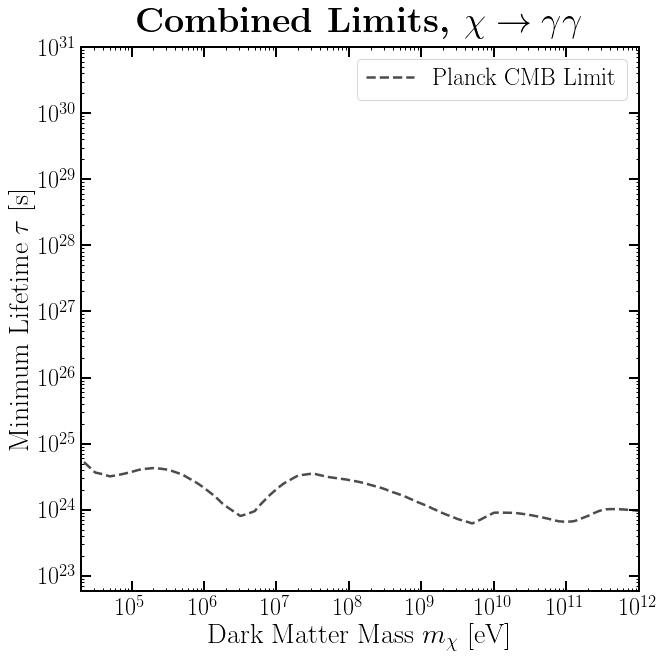

In [21]:
log10mDM_fine = np.log10(10**np.arange(4, 12.5, 0.05) + 2*phys.me*0)
log10tau_fine = np.arange(22, 30, 0.05)
lim_CMB, = plt.plot(
    10**log10mDM_fine, max_xsec_phot_CMB(10**log10mDM_fine, 'decay'), 
    color='black', alpha=0.7, linestyle='dashed'
)

lim_CMB.set_label(r'Planck CMB Limit')

leg = plt.legend(loc=1)

ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')

plt.title(r'\bf{Combined Limits}, $\chi \to \gamma \gamma$')
plt.xlabel(r'Dark Matter Mass $m_\chi$ [eV]')
plt.ylabel(r'Minimum Lifetime $\tau$ [s]')
plt.axis([2e4, 1e12, 6e22, 1e31])

In [154]:
# p-wave structure formation
NFW_subs_data = []
with open('/home/gridgway/Dropbox (MIT)/21cm_pwave/math/data/rho_eff_NFW_subs_pwave.txt') as f:
    for line in f:
        inner_list = [float(num.strip()) for num in line.split(' ') if num]
        NFW_subs_data.append(inner_list)
        
NFW_subs_data = np.array(NFW_subs_data)
NFW_subs_data[:,2] *= .839418
NFW_subs_data[:,0] += 1
sigma_1D_B = 1e-11*phys.c*(1/100)**0.5
NFW_subs_data[:,1] = phys.rho_DM * NFW_subs_data[:,0]**4 * 10**-9 * sigma_1D_B/phys.c

struct_boost_raw = (NFW_subs_data[:,2]/NFW_subs_data[:,1])**2

log10_struct_boost = interp1d(NFW_subs_data[:,0], np.log10(struct_boost_raw))

def struct_boost(rs):
    if rs < NFW_subs_data[-1,0]:
        return 10**log10_struct_boost(rs)
    else:
        return 1.

- RuntimeWarning: The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded

- why are there fewer energy bins in CMB_engloss_arr than the tflists?

In [52]:
CMB_engloss_arr.shape

(11, 321, 51)

In [151]:
# Spectra of CMB as a function of rs
eng = a[3].eng
CMB_spectra = Spectra([
    Spectrum(
        eng, 
        5e-9*phys.CMB_spec(eng, phys.TCMB(rs)) * 
        CMB_engloss_interp(min(a[0][i], .999), rs) * phys.nB*rs**3 * highengphot_tf_interp.dlnz/phys.hubble(rs) / np.sum(
            np.insert(np.diff(eng), 0, eng[1]-eng[0]) * eng * phys.CMB_spec(eng, phys.TCMB(rs))
        ), 
        rs=rs
    )
    for i, rs in enumerate(a[3].rs)
])
CMB_spectra.switch_spec_type()

In [136]:
xes = 0.5 + 0.5*np.tanh([-5., -4.1, -3.2, -2.3, -1.4, -0.5, 0.4, 1.3, 2.2, 3.1, 4])
CMB_engloss_interp = interp2d(xes, highengphot_tf_interp.rs, np.transpose(np.sum(CMB_engloss_arr, 1)))

[0.0001, 10000.0, 1e-44, 5000]

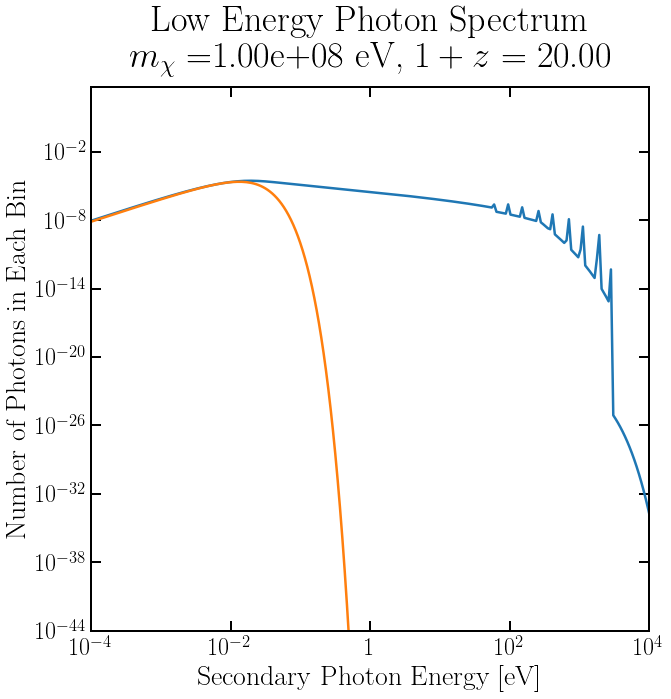

In [152]:
plt.figure()

rs_plot = 20.0

ax = plt.gca()
tf_plot, = a[3].plot(ax, ind=rs_plot, fac=1, indtype='rs')
CMB_plot, = CMB_spectra.plot(ax, ind=rs_plot, indtype='rs')
# tf_plot, = lowengphot_spectra.plot(ax, ind=20)


ax.set_xscale('log')
ax.set_yscale('log')

plt.title('Low Energy Photon Spectrum\n' + r'$m_\chi$ ='
          +'{:.2e}'.format(mDM)
          +r' eV, $1+z$ = '+'{0:.2f}'.format(rs_plot)
         )

#ax.legend((tf_plot, file_plot), ('Transfer Function', 'Reference File'))


plt.xlabel('Secondary Photon Energy [eV]')
plt.ylabel('Number of Photons in Each Bin')
plt.axis([1e-4, 1e4, 1e-44, 5000])

#plt.savefig('/home/gridgway/Desktop/CMB_subtract.png')

In [230]:
temp2 = np.array([
    np.append(rs,compute_fs(
        Spectrum(temp[3].eng, elec_spec, rs=rs, spec_type='N'), 
        Spectrum(temp[3].eng, phot_spec, rs=rs, spec_type='N'),
        np.array([1-xe, 0, 0]), 
        rate_func_decay_eng(rs), 
        highengphot_tf_interp.dlnz/phys.hubble(rs)
    ))
    for (rs, xe, phot_spec, elec_spec) in zip(temp[3].rs[1:], temp[0][1:], temp[3], temp[4])
])
print(temp2[-20:])

AttributeError: 'numpy.ndarray' object has no attribute 'rs'

# NEED TO CHECK

In [393]:
import darkhistory.low_energy.lowE_deposition as lowE_dep
%autoreload

time=-2
tau=1e23
rs_tmp = a1[3][time].rs
print(sum(lowE_dep.compute_fs(
    a1[4][time], 
    a1[3][time], 
    np.array([1-xe_std(rs_tmp),0,0]), 
    rate_func_eng(rs_tmp), 
    .002/phys.hubble(rs_tmp), 
    0
))*rate_func_eng(rs_tmp)*.002/phys.hubble(rs_tmp)/phys.nB/rs_tmp**3)
print(a1[4][time].toteng()+a1[3][time].toteng())

0.0054045385439492315
0.005405394701886692


-Compute T(E,z_in, z_dep) by doing a delta function injection

-Why don't we ever keep track of how much DM is being depleted through annihilation/decay?

-Why don't we go above 5 TeV?

TODO:
- make contour plots
    - Pick a mass and make the plot corresponding to a vertical line going through the contour plot
    - Make a course contour plot
    - Once everything is debugged, make a very fine contour plot
- Clean up this Example12
    - migrate the main evolve function into a main.py that is conspicuous for the casual user
    - Change the inputs so that xe_init and T_init are computed for the user.
    - Make sure that the transfer functions are never seen (take them out of the input)
    - plots comparing back-reaction and no back-reaction
    - allow electron annihilation


- Structure Formation
    - swave
    - on/off switch
    - optimistic/conservative
    - (just a change to the annihilation rate)
    
- minimum lifetime (do this first, structure independent)/maximum cross-section
    - residual plot of with back-reaction vs. not back-react (temperature), contour plots
    - for each mass pick the minimum tau or maximum cross-section and compare the std_switch on or off
    
- New 21cm sensitivity
    - Hongwan's plots, but now with DarkHistory